In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep'''
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.compose import ColumnTransformer 
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import precision_recall_curve, average_precision_score,precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.model_selection import train_test_split, GridSearchCV

'''Algos'''
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

# Data Preparation

## Acquire Data

In [2]:
# We only get the train data set
current_path = os.getcwd()+"\\"
file = os.path.sep.join(["..\\data\\train.csv"])
data = pd.read_csv(current_path + file)
data=data.set_index("Id")

# signal is the target variable
X=data.drop(["signal","BUTTER"], axis=1) # Droping BUTTER variable as is IRRELEVANT
X.columns = X.columns.str.replace(' ', '')
y=pd.DataFrame(data["signal"])

df=pd.read_csv(current_path + file)
df.columns = df.columns.str.strip()
X = np.asarray(df)[:,:-2]
y = np.asarray(df)[:,-1]


## Explore Data

In [61]:
X.shape

(212662, 14)

In [62]:
X.head()

,B_OWNPV_CHI2,B_IPCHI2_OWNPV,B_FDCHI2_OWNPV,B_DIRA_OWNPV,B_PT,Kst_892_0_IP_OWNPV,Kst_892_0_cosThetaH,Kplus_IP_OWNPV,Kplus_P,piminus_IP_OWNPV,piminus_P,gamma_PT,piminus_ETA,Kplus_ETA
Id,,,,,,,,,,,,,,
0,28.878847,2.662533,2924.690991,0.999997,19085.568945,0.569198,-0.575502,0.581565,66850.893711,0.637969,14298.486178,7940.694301,2.628526,2.680116
1,34.233566,0.092746,346.948714,0.999997,6631.244546,0.248707,-0.615941,0.277898,39274.475071,0.148815,11553.163934,3904.681337,3.292504,3.085754
2,36.113632,2.442423,238.553023,0.999986,7740.918989,0.222347,0.249383,0.216576,27757.153899,0.249840,24081.196003,4738.891687,3.433676,3.121906
3,14.286133,6.337556,227.375132,0.999806,6740.281614,0.347316,0.591884,0.306927,10593.207077,0.400748,11343.521945,3308.943750,2.291867,2.200712
4,60.474274,7.632751,106.730650,0.999905,5556.388794,0.204273,0.655850,0.196600,11801.249543,0.223101,25940.693317,4026.326871,3.290073,3.281829


In [63]:
X.describe()

,B_OWNPV_CHI2,B_IPCHI2_OWNPV,B_FDCHI2_OWNPV,B_DIRA_OWNPV,B_PT,Kst_892_0_IP_OWNPV,Kst_892_0_cosThetaH,Kplus_IP_OWNPV,Kplus_P,piminus_IP_OWNPV,piminus_P,gamma_PT,piminus_ETA,Kplus_ETA
count,212662.000000,212662.000000,2.126620e+05,212662.000000,212662.000000,212662.000000,212662.000000,212662.000000,212662.000000,212662.000000,212662.000000,212662.000000,212662.000000,212662.000000
mean,30.917255,2.831039,3.233108e+03,0.999962,9260.664335,0.573487,0.217185,0.581601,29740.464140,0.595178,23615.399265,5781.262866,3.149949,3.166745
std,15.392944,2.216654,1.498588e+04,0.000068,3997.768903,0.417256,0.484779,0.437939,19239.085505,0.460742,16424.509733,2669.985983,0.520862,0.527135
min,0.204442,0.000038,3.138746e+01,0.999500,2500.513932,0.200005,-0.799991,0.064412,3791.228140,0.053244,4952.118133,3000.031840,2.000000,2.000227
25%,19.250309,0.925412,3.851386e+02,0.999961,6527.503234,0.289879,-0.170048,0.292138,15356.298104,0.294970,11921.223058,3887.726863,2.752651,2.760779
50%,29.615744,2.287488,9.017917e+02,0.999989,8336.548930,0.429935,0.241336,0.436257,24379.336211,0.444553,18693.423754,4986.055993,3.128397,3.151240
75%,41.071903,4.426295,2.564877e+03,0.999998,11065.050625,0.703082,0.634683,0.713462,38994.138332,0.731249,30209.322530,6770.025065,3.526473,3.551590
max,108.067413,7.999920,1.971087e+06,1.000000,56327.186960,2.999445,0.999998,4.376841,99995.109721,4.439294,99982.936241,52715.201472,4.499751,4.499966


In [64]:
y.groupby('signal').signal.count()/y["signal"].count().sum()*100

signal
0.0    66.599581
1.0    33.400419
Name: signal, dtype: float64

## Feature engineering

In [65]:
cols=X.columns
Xc=X.copy()

for col1 in cols:
    for col2 in cols:
        Xc[col1+"x"+col2]=Xc[col1]*Xc[col2]

In [144]:
Xc=X.copy()
Xc["LOG_B_FDCHI2_OWNPV"]=np.log(Xc["B_FDCHI2_OWNPV"])
Xc=Xc.drop(["B_FDCHI2_OWNPV"],axis=1)
#Xc["EXP_B_DIRA_OWNPV"]=np.exp(Xc["B_DIRA_OWNPV"])

### Graphs!

In [66]:
db=pd.concat([Xc[supercols], y], axis=1, sort=False)

In [67]:
res=abs(db.corr()).sort_values(by="signal",ascending=False)

In [69]:
cols=X.columns
supercols=res.index[1:20]
supercols

Index(['Kst_892_0_cosThetaHxKst_892_0_cosThetaH', 'Kst_892_0_IP_OWNPVxKplus_P',
       'Kplus_PxKst_892_0_IP_OWNPV', 'Kplus_PxKplus_IP_OWNPV',
       'Kplus_IP_OWNPVxKplus_P', 'piminus_IP_OWNPVxKplus_P',
       'Kplus_Pxpiminus_IP_OWNPV', 'piminus_ETAxB_IPCHI2_OWNPV',
       'B_IPCHI2_OWNPVxpiminus_ETA', 'Kplus_ETAxB_IPCHI2_OWNPV',
       'B_IPCHI2_OWNPVxKplus_ETA', 'B_IPCHI2_OWNPV',
       'B_IPCHI2_OWNPVxB_DIRA_OWNPV', 'B_DIRA_OWNPVxB_IPCHI2_OWNPV',
       'Kst_892_0_IP_OWNPVxB_DIRA_OWNPV', 'B_DIRA_OWNPVxKst_892_0_IP_OWNPV',
       'Kst_892_0_IP_OWNPV', 'Kplus_IP_OWNPVxB_DIRA_OWNPV',
       'B_DIRA_OWNPVxKplus_IP_OWNPV'],
      dtype='object')

In [116]:
X.columns

Index(['B_OWNPV_CHI2', 'B_IPCHI2_OWNPV', 'B_FDCHI2_OWNPV', 'B_DIRA_OWNPV',
       'B_PT', 'Kst_892_0_IP_OWNPV', 'Kst_892_0_cosThetaH', 'Kplus_IP_OWNPV',
       'Kplus_P', 'piminus_IP_OWNPV', 'piminus_P', 'gamma_PT', 'piminus_ETA',
       'Kplus_ETA'],
      dtype='object')

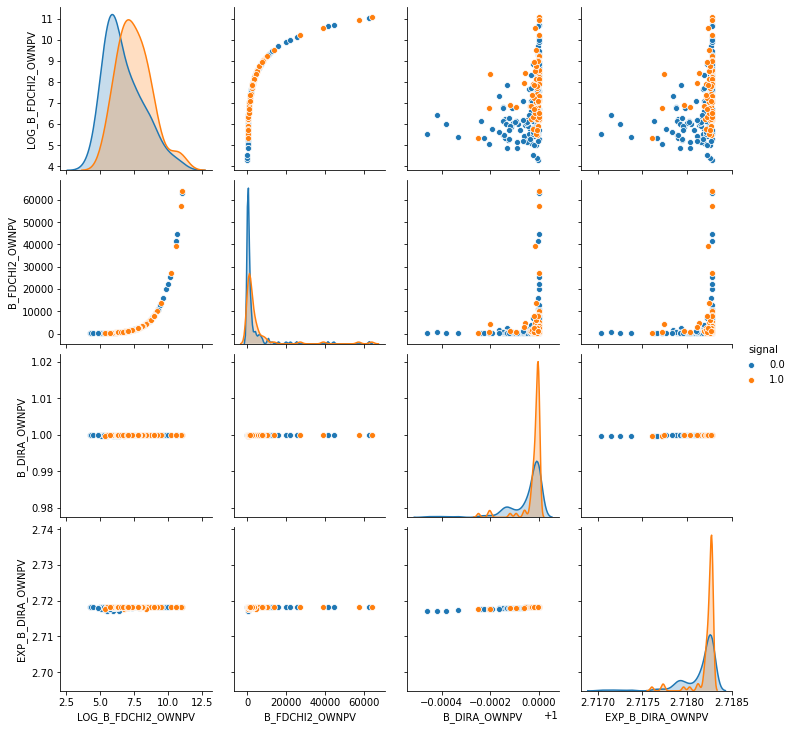

In [135]:
db=pd.concat((Xc[["LOG_B_FDCHI2_OWNPV","B_FDCHI2_OWNPV","B_DIRA_OWNPV","EXP_B_DIRA_OWNPV"]], y), axis=1, sort=False)
sns.pairplot(data=db[::1000],hue="signal")

## Scaling the data

In [3]:
#Standarazing all of the signal variables we could normalize them but this will be likely affected by the precense of outliers
X_scaled=X.copy()
scaler = StandardScaler() 
X_scaled[X_scaled.columns.values] = scaler.fit_transform(X_scaled[X_scaled.columns.values])

In [4]:
X_scaled.describe()

,B_OWNPV_CHI2,B_IPCHI2_OWNPV,B_FDCHI2_OWNPV,B_DIRA_OWNPV,B_PT,Kst_892_0_IP_OWNPV,Kst_892_0_cosThetaH,Kplus_IP_OWNPV,Kplus_P,piminus_IP_OWNPV,piminus_P,gamma_PT,piminus_ETA,Kplus_ETA
count,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05
mean,-7.689786e-17,-2.424404e-16,1.474989e-17,6.123766e-14,5.696404e-16,7.085084e-17,-1.214572e-17,1.904297e-16,-1.719373e-16,-1.490377e-16,-3.372423e-16,3.115288e-16,-7.637162e-16,4.556852e-17
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.995257e+00,-1.277154e+00,-2.136496e-01,-6.768457e+00,-1.690985e+00,-8.950950e-01,-2.098233e+00,-1.180966e+00,-1.348780e+00,-1.176222e+00,-1.136309e+00,-1.041667e+00,-2.207787e+00,-2.212948e+00
25%,-7.579429e-01,-8.596884e-01,-1.900439e-01,-2.022793e-02,-6.836732e-01,-6.796995e-01,-7.987847e-01,-6.609699e-01,-7.476551e-01,-6.515771e-01,-7.119971e-01,-7.091949e-01,-7.627739e-01,-7.701401e-01
50%,-8.455265e-02,-2.452133e-01,-1.555679e-01,3.952731e-01,-2.311583e-01,-3.440399e-01,4.981935e-02,-3.318836e-01,-2.786588e-01,-3.269188e-01,-2.996733e-01,-2.978326e-01,-4.137858e-02,-2.941407e-02
75%,6.596966e-01,7.196702e-01,-4.459077e-02,5.145738e-01,4.513494e-01,3.105881e-01,8.612174e-01,3.010957e-01,4.809842e-01,2.953312e-01,4.014694e-01,3.703257e-01,7.228877e-01,7.300715e-01
max,5.012059e+00,2.331845e+00,1.313142e+02,5.505127e-01,1.177323e+01,5.814091e+00,1.614789e+00,8.666168e+00,3.651671e+00,8.343331e+00,4.649619e+00,1.757839e+01,2.591483e+00,2.529191e+00


Using **Robust Scaling** to avoid outliers effect when scaling

More info in: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html

In [5]:
#Robust scaled to avoid outilers effect when normalizing: 
X_Rscaled=X.copy()
Rscaler = RobustScaler() 
X_Rscaled[X_Rscaled.columns.values] = Rscaler.fit_transform(X_Rscaled[X_Rscaled.columns.values])

In [6]:
X_Rscaled.describe()

,B_OWNPV_CHI2,B_IPCHI2_OWNPV,B_FDCHI2_OWNPV,B_DIRA_OWNPV,B_PT,Kst_892_0_IP_OWNPV,Kst_892_0_cosThetaH,Kplus_IP_OWNPV,Kplus_P,piminus_IP_OWNPV,piminus_P,gamma_PT,piminus_ETA,Kplus_ETA
count,2.126620e+05,212662.000000,2.126620e+05,2.126620e+05,212662.000000,2.126620e+05,2.126620e+05,212662.000000,2.126620e+05,2.126620e+05,212662.000000,2.126620e+05,212662.000000,212662.000000
mean,5.964327e-02,0.155261,1.069539e+00,-7.391022e-01,0.203660,3.474142e-01,-3.001162e-02,0.344970,2.268028e-01,3.452486e-01,0.269135,2.758933e-01,0.027852,0.019607
std,7.053996e-01,0.633170,6.875082e+00,1.869856e+00,0.881042,1.009810e+00,6.024103e-01,1.039433,8.139105e-01,1.056071e+00,0.898098,9.263393e-01,0.673102,0.666574
min,-1.347807e+00,-0.653392,-3.993158e-01,-1.339511e+01,-1.286165,-5.564596e-01,-1.294006e+00,-0.882562,-8.709809e-01,-8.969221e-01,-0.751380,-6.890419e-01,-1.458212,-1.455484
25%,-4.750081e-01,-0.389066,-2.370252e-01,-7.769254e-01,-0.398684,-3.389516e-01,-5.112066e-01,-0.342062,-3.817201e-01,-3.428614e-01,-0.370306,-3.810602e-01,-0.485572,-0.493748
50%,-8.140357e-17,0.000000,2.607809e-17,-1.519405e-12,0.000000,6.717183e-17,1.724517e-17,0.000000,-7.695210e-17,-6.361874e-17,0.000000,1.577725e-16,0.000000,0.000000
75%,5.249919e-01,0.610934,7.629748e-01,2.230746e-01,0.601316,6.610484e-01,4.887934e-01,0.657938,6.182799e-01,6.571386e-01,0.629694,6.189398e-01,0.514428,0.506252
max,3.595139e+00,1.631712,9.038630e+02,2.902751e-01,10.576339,6.218528e+00,9.427517e-01,9.352846,3.198929e+00,9.156377e+00,4.444940,1.655941e+01,1.772181,1.705496


# Model Training and testing

## Logistic regression

In [14]:
#Split between training and test
X_train, X_test, y_train, y_test = train_test_split(X_Rscaled, y, test_size=0.33)
k_fold = StratifiedKFold(n_splits=5,shuffle=True)

In [15]:
#penalty = 'l2'
#C = 1.0
#class_weight = 'balanced'
#n_jobs=1
#solver = 'liblinear'

#model = LogisticRegression(penalty=penalty, C=C,class_weight=class_weight,solver=solver, n_jobs=n_jobs)

IndentationError: unexpected indent (<ipython-input-15-22d20e0a0220>, line 8)

In [ ]:
model=LogisticRegression(C = 1.0)

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),
                                          y_train.values.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    #model
    model.fit(X_train_fold,y_train_fold)
    
    print(model.score(X_train_fold,y_train_fold))
    print(model.score(X_cv_fold,y_cv_fold))
    print()


In [ ]:
score=model.score(X_test,y_test)
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions)

In [ ]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [ ]:
roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

## Random Forest

In [97]:
np.concatenate((cols, supercols[:2]),axis=0)

array(['B_OWNPV_CHI2', 'B_IPCHI2_OWNPV', 'B_FDCHI2_OWNPV', 'B_DIRA_OWNPV',
       'B_PT', 'Kst_892_0_IP_OWNPV', 'Kst_892_0_cosThetaH',
       'Kplus_IP_OWNPV', 'Kplus_P', 'piminus_IP_OWNPV', 'piminus_P',
       'gamma_PT', 'piminus_ETA', 'Kplus_ETA',
       'Kst_892_0_cosThetaHxKst_892_0_cosThetaH',
       'Kst_892_0_IP_OWNPVxKplus_P'], dtype=object)

In [149]:
#Split between training and test
Rscaler=RobustScaler()
Xc_Rscaled=pd.DataFrame(data=Rscaler.fit_transform(Xc))
X_train, X_test, y_train, y_test = train_test_split(X_Rscaled, y, test_size=0.4)
k_fold = StratifiedKFold(n_splits=5,shuffle=True)

In [150]:
model = RandomForestClassifier()

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.values.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    model.fit(X_train_fold, y_train_fold)
    print(model.score(X_train_fold,y_train_fold))
    print(model.score(X_cv_fold,y_cv_fold))
    break
    


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


0.9999902034738481
0.7704937304075236


In [151]:
roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

0.8346413315925487

## XGBoost

In [21]:
#Split between training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=42)

In [22]:
#Split between training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.7, random_state=42)

In [23]:
params_xgb = {'colsample_bytree': 0.8,                 
              'learning_rate': 0.0003,
              'max_depth': 31,
              'subsample': 1,
              'objective':'binary:logistic',
              'eval_metric':'logloss',
              'min_child_weight':3,
              'gamma':0.25,
              'n_estimators':5000,
              'verbosity':0
              }

In [24]:
train_set = xgb.DMatrix(X_train, y_train)
val_set = xgb.DMatrix(X_valid, y_valid)
test_set = xgb.DMatrix(X_test)

clf = xgb.train(params_xgb, train_set,num_boost_round=5000, evals=[(train_set, 'train'), (val_set, 'val')], early_stopping_rounds=100, verbose_eval=100)

[0]	train-logloss:0.69298	val-logloss:0.69304
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 100 rounds.
[100]	train-logloss:0.67864	val-logloss:0.68321
[200]	train-logloss:0.66473	val-logloss:0.67370
[300]	train-logloss:0.65146	val-logloss:0.66480
[400]	train-logloss:0.63865	val-logloss:0.65627
[500]	train-logloss:0.62627	val-logloss:0.64808
[600]	train-logloss:0.61437	val-logloss:0.64033
[700]	train-logloss:0.60290	val-logloss:0.63294
[800]	train-logloss:0.59183	val-logloss:0.62591
[900]	train-logloss:0.58112	val-logloss:0.61917
[1000]	train-logloss:0.57076	val-logloss:0.61276
[1100]	train-logloss:0.56077	val-logloss:0.60667
[1200]	train-logloss:0.55104	val-logloss:0.60076
[1300]	train-logloss:0.54165	val-logloss:0.59517
[1400]	train-logloss:0.53258	val-logloss:0.58985
[1500]	train-logloss:0.52370	val-logloss:0.58464
[1600]	train-logloss:0.51510	val-logloss:0.57968
[1700]	train-logloss:0.50676	va

In [19]:
y_hat_x = clf.predict(test_set)
roc_auc_score(y_test, y_hat_x)

0.843364640179589

## LGBM

https://towardsdatascience.com/understanding-lightgbm-parameters-and-how-to-tune-them-6764e20c6e5b

In [62]:
#Split between training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.95, random_state=42)

In [63]:
#Split between training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.95, random_state=42)

In [64]:
print(X_train.shape,X_valid.shape,X_test.shape)

(191926, 15) (10102, 15) (10634, 15)


In [71]:
params_lgb = {'num_leaves': 127,
          'min_data_in_leaf': 10,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": 2
          }

In [72]:
dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_valid, label=y_valid)

clf = lgb.train(params_lgb, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200)

[LightGBM] [Info] Number of positive: 64053, number of negative: 127873
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000005 seconds, init for row-wise cost 0.010948 seconds
[LightGBM] [Debug] col-wise cost 0.000880 seconds, row-wise cost 0.001399 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 191926, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333738 -> initscore=-0.691327
[LightGBM] [Info] Start training from score -0.691327
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 12
[LightGBM] [Debug] Trained a 

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 14
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[600]	training's auc: 0.881832	valid_1's auc: 0.856835
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Tra

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[1200]	training's auc: 0.909039	valid_1's auc: 0.866012
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Tr

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 13
[1800]	training's auc: 0.927605	valid_1's auc: 0.868654
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Tr

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[3800]	training's auc: 0.966892	valid_1's auc: 0.870842
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Tr

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 33
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 29
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 28
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 30
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 28
[8200]	training's auc: 0.996087	valid_1's auc: 0.871907
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Tr

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 28
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 30
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 26
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 29
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 28
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 24
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 21
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 27
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[Light

[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 22
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 127 and max_depth = 25
[Light

In [73]:
print(roc_auc_score(y_train, clf.predict(X_train)))
print(roc_auc_score(y_test, clf.predict(X_test)))

0.9985633342835791
0.8733888182592984


### Optuna implementation of hyperparamter

**Whitout RobustScaler**

In [89]:
#Split between training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.95, random_state=42)

In [90]:
#Split between training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.95, random_state=42)

In [91]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import optuna.integration.lightgbm as lgb


dtrain = lgb.Dataset(X_train, label=y_train)
dval = lgb.Dataset(X_valid, label=y_valid)

params = {
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "boosting_type": "gbdt",
}

model = lgb.train(
    params, dtrain,10000, valid_sets=[dtrain, dval], verbose_eval=200, early_stopping_rounds=300
)

prediction = np.rint(model.predict(val_x, num_iteration=model.best_iteration))
accuracy = roc_auc_score(val_y, prediction)

best_params = model.params
print("Best params:", best_params)
print("  AUC = {}".format(accuracy))
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

[I 2020-10-31 07:52:48,845] A new study created in memory with name: no-name-045c8c02-f8a8-4aea-89cb-5371bd83fa32









  0%|                                                                                            | 0/7 [00:00<?, ?it/s]








feature_fraction, val_score: -inf:   0%|                                                         | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.874582	valid_1's auc: 0.858868
[400]	training's auc: 0.893804	valid_1's auc: 0.865963
[600]	training's auc: 0.907658	valid_1's auc: 0.868096
[800]	training's auc: 0.918983	valid_1's auc: 0.869023
[1000]	training's auc: 0.929007	valid_1's auc: 0.869583
[1200]	training's auc: 0.93767	valid_1's auc: 0.869805
[1400]	training's auc: 0.945376	valid_1's auc: 0.870262
[1600]	training's auc: 0.952214	valid_1's auc: 0.870392
[1800]	training's auc: 0.958279	valid_1's auc: 0.870825
[2000]	training's auc: 0.963571	valid_1's auc: 0.871301
[2200]	training's auc: 0.968317	valid_1's auc: 0.87105
Early stopping, best iteration is:
[2056]	training's auc: 0.964956	valid_1's auc: 0.871364











feature_fraction, val_score: 0.871364:   0%|                                                     | 0/7 [00:35<?, ?it/s]








feature_fraction, val_score: 0.871364:  14%|######4                                      | 1/7 [00:35<03:31, 35.33s/it][I 2020-10-31 07:53:24,182] Trial 0 finished with value: 0.8713640196855844 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.8713640196855844.









feature_fraction, val_score: 0.871364:  14%|######4                                      | 1/7 [00:35<03:31, 35.33s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.875547	valid_1's auc: 0.859303
[400]	training's auc: 0.894973	valid_1's auc: 0.865814
[600]	training's auc: 0.908714	valid_1's auc: 0.86776
[800]	training's auc: 0.920155	valid_1's auc: 0.868488
[1000]	training's auc: 0.930274	valid_1's auc: 0.86929
[1200]	training's auc: 0.939164	valid_1's auc: 0.869809
[1400]	training's auc: 0.947149	valid_1's auc: 0.870002
[1600]	training's auc: 0.953928	valid_1's auc: 0.870236
[1800]	training's auc: 0.959928	valid_1's auc: 0.869855
Early stopping, best iteration is:
[1618]	training's auc: 0.954511	valid_1's auc: 0.870319











feature_fraction, val_score: 0.871364:  14%|######4                                      | 1/7 [01:03<03:31, 35.33s/it]








feature_fraction, val_score: 0.871364:  29%|############8                                | 2/7 [01:03<02:45, 33.16s/it][I 2020-10-31 07:53:52,265] Trial 1 finished with value: 0.8703187502166788 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.8713640196855844.









feature_fraction, val_score: 0.871364:  29%|############8                                | 2/7 [01:03<02:45, 33.16s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.879878	valid_1's auc: 0.86218
[400]	training's auc: 0.899018	valid_1's auc: 0.867268
[600]	training's auc: 0.913319	valid_1's auc: 0.868975
[800]	training's auc: 0.925045	valid_1's auc: 0.869778
[1000]	training's auc: 0.935345	valid_1's auc: 0.870293
[1200]	training's auc: 0.944193	valid_1's auc: 0.870491
[1400]	training's auc: 0.951808	valid_1's auc: 0.870729
[1600]	training's auc: 0.958551	valid_1's auc: 0.870605
Early stopping, best iteration is:
[1307]	training's auc: 0.948474	valid_1's auc: 0.871021











feature_fraction, val_score: 0.871364:  29%|############8                                | 2/7 [01:26<02:45, 33.16s/it]








feature_fraction, val_score: 0.871364:  43%|###################2                         | 3/7 [01:26<02:00, 30.14s/it][I 2020-10-31 07:54:15,374] Trial 2 finished with value: 0.8710207342545466 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.8713640196855844.









feature_fraction, val_score: 0.871364:  43%|###################2                         | 3/7 [01:26<02:00, 30.14s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.878358	valid_1's auc: 0.86121
[400]	training's auc: 0.897281	valid_1's auc: 0.867287
[600]	training's auc: 0.911499	valid_1's auc: 0.869255
[800]	training's auc: 0.923055	valid_1's auc: 0.869479
[1000]	training's auc: 0.933161	valid_1's auc: 0.869667
[1200]	training's auc: 0.941983	valid_1's auc: 0.869957
[1400]	training's auc: 0.949582	valid_1's auc: 0.870534
[1600]	training's auc: 0.956276	valid_1's auc: 0.87079
[1800]	training's auc: 0.962089	valid_1's auc: 0.870769
Early stopping, best iteration is:
[1531]	training's auc: 0.954069	valid_1's auc: 0.870981











feature_fraction, val_score: 0.871364:  43%|###################2                         | 3/7 [01:54<02:00, 30.14s/it]








feature_fraction, val_score: 0.871364:  57%|#########################7                   | 4/7 [01:54<01:28, 29.59s/it][I 2020-10-31 07:54:43,684] Trial 3 finished with value: 0.8709812959566029 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.8713640196855844.









feature_fraction, val_score: 0.871364:  57%|#########################7                   | 4/7 [01:54<01:28, 29.59s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.87766	valid_1's auc: 0.861213
[400]	training's auc: 0.896779	valid_1's auc: 0.86718
[600]	training's auc: 0.910675	valid_1's auc: 0.868835
[800]	training's auc: 0.92246	valid_1's auc: 0.870229
[1000]	training's auc: 0.932628	valid_1's auc: 0.870456
[1200]	training's auc: 0.941338	valid_1's auc: 0.870898
[1400]	training's auc: 0.949005	valid_1's auc: 0.870718
[1600]	training's auc: 0.955824	valid_1's auc: 0.870724
[1800]	training's auc: 0.961638	valid_1's auc: 0.870895
Early stopping, best iteration is:
[1543]	training's auc: 0.953972	valid_1's auc: 0.871119











feature_fraction, val_score: 0.871364:  57%|#########################7                   | 4/7 [02:24<01:28, 29.59s/it]








feature_fraction, val_score: 0.871364:  71%|################################1            | 5/7 [02:24<00:59, 29.58s/it][I 2020-10-31 07:55:13,230] Trial 4 finished with value: 0.8711186896239075 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.8713640196855844.









feature_fraction, val_score: 0.871364:  71%|################################1            | 5/7 [02:24<00:59, 29.58s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.878957	valid_1's auc: 0.863041
[400]	training's auc: 0.897965	valid_1's auc: 0.868301
[600]	training's auc: 0.912189	valid_1's auc: 0.869828
[800]	training's auc: 0.923959	valid_1's auc: 0.870287
[1000]	training's auc: 0.934185	valid_1's auc: 0.870712
[1200]	training's auc: 0.942845	valid_1's auc: 0.871001
[1400]	training's auc: 0.950551	valid_1's auc: 0.870935
[1600]	training's auc: 0.957185	valid_1's auc: 0.87108
[1800]	training's auc: 0.963034	valid_1's auc: 0.871498
[2000]	training's auc: 0.968121	valid_1's auc: 0.871243
Early stopping, best iteration is:
[1799]	training's auc: 0.963005	valid_1's auc: 0.871534











feature_fraction, val_score: 0.871534:  71%|################################1            | 5/7 [02:58<00:59, 29.58s/it]








feature_fraction, val_score: 0.871534:  86%|######################################5      | 6/7 [02:58<00:31, 31.09s/it][I 2020-10-31 07:55:47,849] Trial 5 finished with value: 0.8715344037320201 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 5 with value: 0.8715344037320201.









feature_fraction, val_score: 0.871534:  86%|######################################5      | 6/7 [02:59<00:31, 31.09s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.87036	valid_1's auc: 0.854761
[400]	training's auc: 0.890085	valid_1's auc: 0.862781
[600]	training's auc: 0.904149	valid_1's auc: 0.865423
[800]	training's auc: 0.915566	valid_1's auc: 0.867183
[1000]	training's auc: 0.925511	valid_1's auc: 0.86782
[1200]	training's auc: 0.934188	valid_1's auc: 0.868567
[1400]	training's auc: 0.941663	valid_1's auc: 0.869234
[1600]	training's auc: 0.94859	valid_1's auc: 0.869017
[1800]	training's auc: 0.954807	valid_1's auc: 0.869036
[2000]	training's auc: 0.960247	valid_1's auc: 0.869295











feature_fraction, val_score: 0.871534:  86%|######################################5      | 6/7 [03:28<00:31, 31.09s/it]








feature_fraction, val_score: 0.871534: 100%|#############################################| 7/7 [03:28<00:00, 30.61s/it]

Early stopping, best iteration is:
[1743]	training's auc: 0.95309	valid_1's auc: 0.869454


[I 2020-10-31 07:56:17,326] Trial 6 finished with value: 0.8694541549660126 and parameters: {'feature_fraction': 0.4}. Best is trial 5 with value: 0.8715344037320201.
feature_fraction, val_score: 0.871534: 100%|#############################################| 7/7 [03:28<00:00, 29.78s/it]









  0%|                                                                                           | 0/20 [00:00<?, ?it/s]








num_leaves, val_score: 0.871534:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.873326	valid_1's auc: 0.860728
[400]	training's auc: 0.89019	valid_1's auc: 0.866227
[600]	training's auc: 0.902079	valid_1's auc: 0.867807
[800]	training's auc: 0.912334	valid_1's auc: 0.868827
[1000]	training's auc: 0.921189	valid_1's auc: 0.869066
[1200]	training's auc: 0.929186	valid_1's auc: 0.869759
[1400]	training's auc: 0.936356	valid_1's auc: 0.870308
[1600]	training's auc: 0.942625	valid_1's auc: 0.870756
[1800]	training's auc: 0.94842	valid_1's auc: 0.87095











num_leaves, val_score: 0.871534:   0%|                                                          | 0/20 [00:32<?, ?it/s]








num_leaves, val_score: 0.871534:   5%|##5                                               | 1/20 [00:32<10:21, 32.70s/it][I 2020-10-31 07:56:50,037] Trial 7 finished with value: 0.870986507288246 and parameters: {'num_leaves': 24}. Best is trial 7 with value: 0.870986507288246.









num_leaves, val_score: 0.871534:   5%|##5                                               | 1/20 [00:32<10:21, 32.70s/it]

Early stopping, best iteration is:
[1684]	training's auc: 0.945149	valid_1's auc: 0.870987
Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.960753	valid_1's auc: 0.867099
[400]	training's auc: 0.992745	valid_1's auc: 0.866653











num_leaves, val_score: 0.871534:   5%|##5                                               | 1/20 [00:46<10:21, 32.70s/it]








num_leaves, val_score: 0.871534:  10%|#####                                             | 2/20 [00:46<08:05, 26.96s/it][I 2020-10-31 07:57:03,597] Trial 8 finished with value: 0.8675093566589005 and parameters: {'num_leaves': 229}. Best is trial 7 with value: 0.870986507288246.









num_leaves, val_score: 0.871534:  10%|#####                                             | 2/20 [00:46<08:05, 26.96s/it]

Early stopping, best iteration is:
[245]	training's auc: 0.972104	valid_1's auc: 0.867509
Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.934471	valid_1's auc: 0.867076
[400]	training's auc: 0.971616	valid_1's auc: 0.868347
[600]	training's auc: 0.989326	valid_1's auc: 0.86782
Early stopping, best iteration is:
[397]	training's auc: 0.971284	valid_1's auc: 0.868452











num_leaves, val_score: 0.871534:  10%|#####                                             | 2/20 [01:01<08:05, 26.96s/it]








num_leaves, val_score: 0.871534:  15%|#######5                                          | 3/20 [01:01<06:37, 23.38s/it][I 2020-10-31 07:57:18,620] Trial 9 finished with value: 0.8684516360821121 and parameters: {'num_leaves': 142}. Best is trial 7 with value: 0.870986507288246.









num_leaves, val_score: 0.871534:  15%|#######5                                          | 3/20 [01:01<06:37, 23.38s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.855518	valid_1's auc: 0.850491
[400]	training's auc: 0.868659	valid_1's auc: 0.85968
[600]	training's auc: 0.876751	valid_1's auc: 0.864059
[800]	training's auc: 0.882683	valid_1's auc: 0.866336
[1000]	training's auc: 0.887742	valid_1's auc: 0.867941
[1200]	training's auc: 0.892283	valid_1's auc: 0.869078
[1400]	training's auc: 0.896339	valid_1's auc: 0.870044
[1600]	training's auc: 0.900211	valid_1's auc: 0.870931
[1800]	training's auc: 0.903804	valid_1's auc: 0.871309
[2000]	training's auc: 0.907271	valid_1's auc: 0.871883
[2200]	training's auc: 0.910469	valid_1's auc: 0.872133
[2400]	training's auc: 0.913578	valid_1's auc: 0.872531
[2600]	training's auc: 0.916489	valid_1's auc: 0.872601
[2800]	training's auc: 0.919249	valid_1's auc: 0.872683
[3000]	training's auc: 0.921916	valid_1's auc: 0.872877
[3200]	training's auc: 0.924513	valid_1's auc: 0.87301
[3400]	training's auc: 0.927015	valid_1's auc: 0










num_leaves, val_score: 0.873178:  15%|#######5                                          | 3/20 [01:55<06:37, 23.38s/it]








num_leaves, val_score: 0.873178:  20%|##########                                        | 4/20 [01:55<08:40, 32.52s/it][I 2020-10-31 07:58:12,486] Trial 10 finished with value: 0.8731780930633422 and parameters: {'num_leaves': 10}. Best is trial 10 with value: 0.8731780930633422.









num_leaves, val_score: 0.873178:  20%|##########                                        | 4/20 [01:55<08:40, 32.52s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.855518	valid_1's auc: 0.850491
[400]	training's auc: 0.868659	valid_1's auc: 0.85968
[600]	training's auc: 0.876751	valid_1's auc: 0.864059
[800]	training's auc: 0.882683	valid_1's auc: 0.866336
[1000]	training's auc: 0.887742	valid_1's auc: 0.867941
[1200]	training's auc: 0.892283	valid_1's auc: 0.869078
[1400]	training's auc: 0.896339	valid_1's auc: 0.870044
[1600]	training's auc: 0.900211	valid_1's auc: 0.870931
[1800]	training's auc: 0.903804	valid_1's auc: 0.871309
[2000]	training's auc: 0.907271	valid_1's auc: 0.871883
[2200]	training's auc: 0.910469	valid_1's auc: 0.872133
[2400]	training's auc: 0.913578	valid_1's auc: 0.872531
[2600]	training's auc: 0.916489	valid_1's auc: 0.872601
[2800]	training's auc: 0.919249	valid_1's auc: 0.872683
[3000]	training's auc: 0.921916	valid_1's auc: 0.872877
[3200]	training's auc: 0.924513	valid_1's auc: 0.87301
[3400]	training's auc: 0.927015	valid_1's auc: 0










num_leaves, val_score: 0.873178:  20%|##########                                        | 4/20 [02:51<08:40, 32.52s/it]








num_leaves, val_score: 0.873178:  25%|############5                                     | 5/20 [02:51<09:52, 39.53s/it][I 2020-10-31 07:59:08,374] Trial 11 finished with value: 0.8731780930633422 and parameters: {'num_leaves': 10}. Best is trial 10 with value: 0.8731780930633422.









num_leaves, val_score: 0.873178:  25%|############5                                     | 5/20 [02:51<09:52, 39.53s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.836607	valid_1's auc: 0.836573
[400]	training's auc: 0.847701	valid_1's auc: 0.846082
[600]	training's auc: 0.854104	valid_1's auc: 0.850999
[800]	training's auc: 0.858775	valid_1's auc: 0.854551
[1000]	training's auc: 0.86268	valid_1's auc: 0.857411
[1200]	training's auc: 0.865748	valid_1's auc: 0.85965
[1400]	training's auc: 0.868396	valid_1's auc: 0.861321
[1600]	training's auc: 0.870658	valid_1's auc: 0.86296
[1800]	training's auc: 0.872685	valid_1's auc: 0.86435
[2000]	training's auc: 0.874402	valid_1's auc: 0.865378
[2200]	training's auc: 0.876004	valid_1's auc: 0.866361
[2400]	training's auc: 0.877479	valid_1's auc: 0.867073
[2600]	training's auc: 0.878832	valid_1's auc: 0.867774
[2800]	training's auc: 0.880073	valid_1's auc: 0.868374
[3000]	training's auc: 0.881259	valid_1's auc: 0.868877
[3200]	training's auc: 0.882437	valid_1's auc: 0.869459
[3400]	training's auc: 0.883436	valid_1's auc: 0.8










num_leaves, val_score: 0.873178:  25%|############5                                     | 5/20 [04:03<09:52, 39.53s/it]








num_leaves, val_score: 0.873178:  30%|###############                                   | 6/20 [04:03<11:32, 49.44s/it][I 2020-10-31 08:00:20,946] Trial 12 finished with value: 0.8720418461098182 and parameters: {'num_leaves': 4}. Best is trial 10 with value: 0.8731780930633422.









num_leaves, val_score: 0.873178:  30%|###############                                   | 6/20 [04:03<11:32, 49.44s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.897628	valid_1's auc: 0.865278
[400]	training's auc: 0.924756	valid_1's auc: 0.867942
[600]	training's auc: 0.944381	valid_1's auc: 0.869015
[800]	training's auc: 0.959318	valid_1's auc: 0.868913
[1000]	training's auc: 0.970594	valid_1's auc: 0.86878
Early stopping, best iteration is:
[759]	training's auc: 0.956575	valid_1's auc: 0.869176











num_leaves, val_score: 0.873178:  30%|###############                                   | 6/20 [04:22<11:32, 49.44s/it]








num_leaves, val_score: 0.873178:  35%|#################5                                | 7/20 [04:22<08:41, 40.15s/it][I 2020-10-31 08:00:39,405] Trial 13 finished with value: 0.869176231999652 and parameters: {'num_leaves': 60}. Best is trial 10 with value: 0.8731780930633422.









num_leaves, val_score: 0.873178:  35%|#################5                                | 7/20 [04:22<08:41, 40.15s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.910164	valid_1's auc: 0.867988
[400]	training's auc: 0.942236	valid_1's auc: 0.870054
[600]	training's auc: 0.963473	valid_1's auc: 0.870893
[800]	training's auc: 0.977446	valid_1's auc: 0.870695











num_leaves, val_score: 0.873178:  35%|#################5                                | 7/20 [04:38<08:41, 40.15s/it]










Early stopping, best iteration is:
[571]	training's auc: 0.960877	valid_1's auc: 0.871044


num_leaves, val_score: 0.873178:  40%|####################                              | 8/20 [04:38<06:35, 32.97s/it][I 2020-10-31 08:00:55,624] Trial 14 finished with value: 0.8710438761001486 and parameters: {'num_leaves': 84}. Best is trial 10 with value: 0.8731780930633422.









num_leaves, val_score: 0.873178:  40%|####################                              | 8/20 [04:38<06:35, 32.97s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.83006	valid_1's auc: 0.830265
[400]	training's auc: 0.841241	valid_1's auc: 0.840626
[600]	training's auc: 0.846913	valid_1's auc: 0.845357
[800]	training's auc: 0.850849	valid_1's auc: 0.848596
[1000]	training's auc: 0.854019	valid_1's auc: 0.850968
[1200]	training's auc: 0.856628	valid_1's auc: 0.853028
[1400]	training's auc: 0.859	valid_1's auc: 0.854876
[1600]	training's auc: 0.861007	valid_1's auc: 0.856402
[1800]	training's auc: 0.862759	valid_1's auc: 0.857589
[2000]	training's auc: 0.864345	valid_1's auc: 0.858748
[2200]	training's auc: 0.865752	valid_1's auc: 0.859683
[2400]	training's auc: 0.867028	valid_1's auc: 0.860711
[2600]	training's auc: 0.868167	valid_1's auc: 0.861531
[2800]	training's auc: 0.869232	valid_1's auc: 0.86235
[3000]	training's auc: 0.870224	valid_1's auc: 0.863093
[3200]	training's auc: 0.871102	valid_1's auc: 0.863769
[3400]	training's auc: 0.871953	valid_1's auc: 0.86










num_leaves, val_score: 0.873178:  40%|####################                              | 8/20 [05:50<06:35, 32.97s/it]








num_leaves, val_score: 0.873178:  45%|######################5                           | 9/20 [05:50<08:13, 44.85s/it][I 2020-10-31 08:02:08,184] Trial 15 finished with value: 0.8673905559629669 and parameters: {'num_leaves': 3}. Best is trial 10 with value: 0.8731780930633422.









num_leaves, val_score: 0.873178:  45%|######################5                           | 9/20 [05:50<08:13, 44.85s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.934471	valid_1's auc: 0.867076
[400]	training's auc: 0.971616	valid_1's auc: 0.868347
[600]	training's auc: 0.989326	valid_1's auc: 0.86782
Early stopping, best iteration is:
[397]	training's auc: 0.971284	valid_1's auc: 0.868452











num_leaves, val_score: 0.873178:  45%|######################5                           | 9/20 [06:03<08:13, 44.85s/it]








num_leaves, val_score: 0.873178:  50%|########################5                        | 10/20 [06:03<05:52, 35.24s/it][I 2020-10-31 08:02:20,998] Trial 16 finished with value: 0.8684516360821121 and parameters: {'num_leaves': 142}. Best is trial 10 with value: 0.8731780930633422.









num_leaves, val_score: 0.873178:  50%|########################5                        | 10/20 [06:03<05:52, 35.24s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.901556	valid_1's auc: 0.866214
[400]	training's auc: 0.930307	valid_1's auc: 0.868472
[600]	training's auc: 0.950525	valid_1's auc: 0.868381
[800]	training's auc: 0.965548	valid_1's auc: 0.868588
[1000]	training's auc: 0.976425	valid_1's auc: 0.86844
[1200]	training's auc: 0.984096	valid_1's auc: 0.867991
Early stopping, best iteration is:
[900]	training's auc: 0.971487	valid_1's auc: 0.868806











num_leaves, val_score: 0.873178:  50%|########################5                        | 10/20 [06:24<05:52, 35.24s/it]








num_leaves, val_score: 0.873178:  55%|##########################9                      | 11/20 [06:24<04:39, 31.03s/it][I 2020-10-31 08:02:42,225] Trial 17 finished with value: 0.8688060949615035 and parameters: {'num_leaves': 67}. Best is trial 10 with value: 0.8731780930633422.









num_leaves, val_score: 0.873178:  55%|##########################9                      | 11/20 [06:24<04:39, 31.03s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.957007	valid_1's auc: 0.866982
[400]	training's auc: 0.990284	valid_1's auc: 0.867858
[600]	training's auc: 0.998646	valid_1's auc: 0.867942
[800]	training's auc: 0.999907	valid_1's auc: 0.868273
[1000]	training's auc: 0.999997	valid_1's auc: 0.867696
Early stopping, best iteration is:
[839]	training's auc: 0.99995	valid_1's auc: 0.868459











num_leaves, val_score: 0.873178:  55%|##########################9                      | 11/20 [06:51<04:39, 31.03s/it]








num_leaves, val_score: 0.873178:  60%|#############################4                   | 12/20 [06:51<03:58, 29.81s/it][I 2020-10-31 08:03:09,181] Trial 18 finished with value: 0.8684594089157494 and parameters: {'num_leaves': 214}. Best is trial 10 with value: 0.8731780930633422.









num_leaves, val_score: 0.873178:  60%|#############################4                   | 12/20 [06:51<03:58, 29.81s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.882726	valid_1's auc: 0.863001
[400]	training's auc: 0.903364	valid_1's auc: 0.867719
[600]	training's auc: 0.918641	valid_1's auc: 0.868625
[800]	training's auc: 0.931417	valid_1's auc: 0.869679
[1000]	training's auc: 0.942271	valid_1's auc: 0.870004
[1200]	training's auc: 0.951461	valid_1's auc: 0.870065
[1400]	training's auc: 0.959022	valid_1's auc: 0.870398
[1600]	training's auc: 0.965666	valid_1's auc: 0.870133
Early stopping, best iteration is:
[1320]	training's auc: 0.956179	valid_1's auc: 0.870525











num_leaves, val_score: 0.873178:  60%|#############################4                   | 12/20 [07:19<03:58, 29.81s/it]








num_leaves, val_score: 0.873178:  65%|###############################8                 | 13/20 [07:19<03:23, 29.09s/it][I 2020-10-31 08:03:36,601] Trial 19 finished with value: 0.8705254810931342 and parameters: {'num_leaves': 36}. Best is trial 10 with value: 0.8731780930633422.









num_leaves, val_score: 0.873178:  65%|###############################8                 | 13/20 [07:19<03:23, 29.09s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.920239	valid_1's auc: 0.866619
[400]	training's auc: 0.955363	valid_1's auc: 0.868686
[600]	training's auc: 0.976143	valid_1's auc: 0.868972
[800]	training's auc: 0.988348	valid_1's auc: 0.869401
[1000]	training's auc: 0.994719	valid_1's auc: 0.86931
[1200]	training's auc: 0.997726	valid_1's auc: 0.869618
[1400]	training's auc: 0.999124	valid_1's auc: 0.868825
Early stopping, best iteration is:
[1112]	training's auc: 0.996748	valid_1's auc: 0.869682











num_leaves, val_score: 0.873178:  65%|###############################8                 | 13/20 [07:46<03:23, 29.09s/it]








num_leaves, val_score: 0.873178:  70%|##################################3              | 14/20 [07:46<02:51, 28.64s/it][I 2020-10-31 08:04:04,177] Trial 20 finished with value: 0.8696818194966958 and parameters: {'num_leaves': 107}. Best is trial 10 with value: 0.8731780930633422.









num_leaves, val_score: 0.873178:  70%|##################################3              | 14/20 [07:46<02:51, 28.64s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.83006	valid_1's auc: 0.830265
[400]	training's auc: 0.841241	valid_1's auc: 0.840626
[600]	training's auc: 0.846913	valid_1's auc: 0.845357
[800]	training's auc: 0.850849	valid_1's auc: 0.848596
[1000]	training's auc: 0.854019	valid_1's auc: 0.850968
[1200]	training's auc: 0.856628	valid_1's auc: 0.853028
[1400]	training's auc: 0.859	valid_1's auc: 0.854876
[1600]	training's auc: 0.861007	valid_1's auc: 0.856402
[1800]	training's auc: 0.862759	valid_1's auc: 0.857589
[2000]	training's auc: 0.864345	valid_1's auc: 0.858748
[2200]	training's auc: 0.865752	valid_1's auc: 0.859683
[2400]	training's auc: 0.867028	valid_1's auc: 0.860711
[2600]	training's auc: 0.868167	valid_1's auc: 0.861531
[2800]	training's auc: 0.869232	valid_1's auc: 0.86235
[3000]	training's auc: 0.870224	valid_1's auc: 0.863093
[3200]	training's auc: 0.871102	valid_1's auc: 0.863769
[3400]	training's auc: 0.871953	valid_1's auc: 0.86










num_leaves, val_score: 0.873178:  70%|##################################3              | 14/20 [08:56<02:51, 28.64s/it]








num_leaves, val_score: 0.873178:  75%|####################################7            | 15/20 [08:56<03:24, 40.97s/it][I 2020-10-31 08:05:13,909] Trial 21 finished with value: 0.8673905559629669 and parameters: {'num_leaves': 3}. Best is trial 10 with value: 0.8731780930633422.









num_leaves, val_score: 0.873178:  75%|####################################7            | 15/20 [08:56<03:24, 40.97s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848717	valid_1's auc: 0.845411
[400]	training's auc: 0.860833	valid_1's auc: 0.854344
[600]	training's auc: 0.86803	valid_1's auc: 0.858974
[800]	training's auc: 0.873422	valid_1's auc: 0.862437
[1000]	training's auc: 0.87777	valid_1's auc: 0.865005
[1200]	training's auc: 0.881408	valid_1's auc: 0.866475
[1400]	training's auc: 0.884759	valid_1's auc: 0.867722
[1600]	training's auc: 0.887727	valid_1's auc: 0.868582
[1800]	training's auc: 0.890366	valid_1's auc: 0.869494
[2000]	training's auc: 0.892886	valid_1's auc: 0.870206
[2200]	training's auc: 0.895212	valid_1's auc: 0.870757
[2400]	training's auc: 0.897551	valid_1's auc: 0.871294
[2600]	training's auc: 0.899723	valid_1's auc: 0.871483
[2800]	training's auc: 0.90178	valid_1's auc: 0.871782
[3000]	training's auc: 0.903853	valid_1's auc: 0.872073
[3200]	training's auc: 0.905834	valid_1's auc: 0.872122
[3400]	training's auc: 0.907829	valid_1's auc: 0.










num_leaves, val_score: 0.873470:  75%|####################################7            | 15/20 [10:09<03:24, 40.97s/it]








num_leaves, val_score: 0.873470:  80%|#######################################2         | 16/20 [10:09<03:21, 50.46s/it][I 2020-10-31 08:06:26,502] Trial 22 finished with value: 0.8734701042906704 and parameters: {'num_leaves': 7}. Best is trial 22 with value: 0.8734701042906704.









num_leaves, val_score: 0.873470:  80%|#######################################2         | 16/20 [10:09<03:21, 50.46s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.886894	valid_1's auc: 0.864518
[400]	training's auc: 0.909366	valid_1's auc: 0.86878
[600]	training's auc: 0.925849	valid_1's auc: 0.870043
[800]	training's auc: 0.939445	valid_1's auc: 0.870705
[1000]	training's auc: 0.950732	valid_1's auc: 0.870874
[1200]	training's auc: 0.960105	valid_1's auc: 0.870815
Early stopping, best iteration is:
[998]	training's auc: 0.950652	valid_1's auc: 0.870906











num_leaves, val_score: 0.873470:  80%|#######################################2         | 16/20 [10:29<03:21, 50.46s/it]








num_leaves, val_score: 0.873470:  85%|#########################################6       | 17/20 [10:29<02:04, 41.40s/it][I 2020-10-31 08:06:46,772] Trial 23 finished with value: 0.8709063499413615 and parameters: {'num_leaves': 42}. Best is trial 22 with value: 0.8734701042906704.









num_leaves, val_score: 0.873470:  85%|#########################################6       | 17/20 [10:29<02:04, 41.40s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.816346	valid_1's auc: 0.815697
[400]	training's auc: 0.827685	valid_1's auc: 0.827543
[600]	training's auc: 0.833119	valid_1's auc: 0.832948
[800]	training's auc: 0.836309	valid_1's auc: 0.836315
[1000]	training's auc: 0.838435	valid_1's auc: 0.838302
[1200]	training's auc: 0.839961	valid_1's auc: 0.839741
[1400]	training's auc: 0.841109	valid_1's auc: 0.840844
[1600]	training's auc: 0.842065	valid_1's auc: 0.841588
[1800]	training's auc: 0.8429	valid_1's auc: 0.8423
[2000]	training's auc: 0.843657	valid_1's auc: 0.842926
[2200]	training's auc: 0.844335	valid_1's auc: 0.84345
[2400]	training's auc: 0.844968	valid_1's auc: 0.844013
[2600]	training's auc: 0.845525	valid_1's auc: 0.84447
[2800]	training's auc: 0.846051	valid_1's auc: 0.844865
[3000]	training's auc: 0.846521	valid_1's auc: 0.845227
[3200]	training's auc: 0.846956	valid_1's auc: 0.845578
[3400]	training's auc: 0.847356	valid_1's auc: 0.845










num_leaves, val_score: 0.873470:  85%|#########################################6       | 17/20 [11:39<02:04, 41.40s/it]








num_leaves, val_score: 0.873470:  90%|############################################1    | 18/20 [11:39<01:40, 50.07s/it][I 2020-10-31 08:07:57,075] Trial 24 finished with value: 0.8476142589983247 and parameters: {'num_leaves': 2}. Best is trial 22 with value: 0.8734701042906704.









num_leaves, val_score: 0.873470:  90%|############################################1    | 18/20 [11:39<01:40, 50.07s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.945176	valid_1's auc: 0.867549
[400]	training's auc: 0.981745	valid_1's auc: 0.868387
Early stopping, best iteration is:
[284]	training's auc: 0.964599	valid_1's auc: 0.869318











num_leaves, val_score: 0.873470:  90%|############################################1    | 18/20 [11:53<01:40, 50.07s/it]








num_leaves, val_score: 0.873470:  95%|##############################################5  | 19/20 [11:53<00:39, 39.15s/it][I 2020-10-31 08:08:10,758] Trial 25 finished with value: 0.8693182628688425 and parameters: {'num_leaves': 173}. Best is trial 22 with value: 0.8734701042906704.









num_leaves, val_score: 0.873470:  95%|##############################################5  | 19/20 [11:53<00:39, 39.15s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.879872	valid_1's auc: 0.862595
[400]	training's auc: 0.899094	valid_1's auc: 0.867087
[600]	training's auc: 0.913315	valid_1's auc: 0.868437
[800]	training's auc: 0.925319	valid_1's auc: 0.868805
[1000]	training's auc: 0.935567	valid_1's auc: 0.869367
[1200]	training's auc: 0.9445	valid_1's auc: 0.869232
[1400]	training's auc: 0.952254	valid_1's auc: 0.869422
[1600]	training's auc: 0.958883	valid_1's auc: 0.869717
[1800]	training's auc: 0.964921	valid_1's auc: 0.869513
Early stopping, best iteration is:
[1529]	training's auc: 0.956622	valid_1's auc: 0.869813











num_leaves, val_score: 0.873470:  95%|##############################################5  | 19/20 [12:22<00:39, 39.15s/it]








num_leaves, val_score: 0.873470: 100%|#################################################| 20/20 [12:22<00:00, 37.13s/it]









  0%|                                                                                           | 0/10 [00:00<?, ?it/s]








bagging, val_score: 0.873470:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848454	valid_1's auc: 0.845707
[400]	training's auc: 0.860686	valid_1's auc: 0.854834
[600]	training's auc: 0.868129	valid_1's auc: 0.85998
[800]	training's auc: 0.873603	valid_1's auc: 0.863
[1000]	training's auc: 0.878056	valid_1's auc: 0.865257
[1200]	training's auc: 0.881797	valid_1's auc: 0.867
[1400]	training's auc: 0.885079	valid_1's auc: 0.868192
[1600]	training's auc: 0.888007	valid_1's auc: 0.868906
[1800]	training's auc: 0.890725	valid_1's auc: 0.869377
[2000]	training's auc: 0.893299	valid_1's auc: 0.870035
[2200]	training's auc: 0.895817	valid_1's auc: 0.870745
[2400]	training's auc: 0.898145	valid_1's auc: 0.871304
[2600]	training's auc: 0.900385	valid_1's auc: 0.871744
[2800]	training's auc: 0.902552	valid_1's auc: 0.872116
[3000]	training's auc: 0.904667	valid_1's auc: 0.872477
[3200]	training's auc: 0.906761	valid_1's auc: 0.872921
[3400]	training's auc: 0.908764	valid_1's auc: 0.8730










bagging, val_score: 0.874608:   0%|                                                             | 0/10 [01:26<?, ?it/s]








bagging, val_score: 0.874608:  10%|#####3                                               | 1/10 [01:26<12:57, 86.36s/it][I 2020-10-31 08:10:06,218] Trial 27 finished with value: 0.8746081177972937 and parameters: {'bagging_fraction': 0.9493002673549722, 'bagging_freq': 5}. Best is trial 27 with value: 0.8746081177972937.









bagging, val_score: 0.874608:  10%|#####3                                               | 1/10 [01:26<12:57, 86.36s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848692	valid_1's auc: 0.8452
[400]	training's auc: 0.860856	valid_1's auc: 0.854618
[600]	training's auc: 0.868188	valid_1's auc: 0.859307
[800]	training's auc: 0.873607	valid_1's auc: 0.862638
[1000]	training's auc: 0.877998	valid_1's auc: 0.86503
[1200]	training's auc: 0.881626	valid_1's auc: 0.86669
[1400]	training's auc: 0.884913	valid_1's auc: 0.867958
[1600]	training's auc: 0.887839	valid_1's auc: 0.868747
[1800]	training's auc: 0.890547	valid_1's auc: 0.869384
[2000]	training's auc: 0.89311	valid_1's auc: 0.869803
[2200]	training's auc: 0.895513	valid_1's auc: 0.870132
[2400]	training's auc: 0.897744	valid_1's auc: 0.870559
[2600]	training's auc: 0.899961	valid_1's auc: 0.871056
[2800]	training's auc: 0.902103	valid_1's auc: 0.871376
[3000]	training's auc: 0.90412	valid_1's auc: 0.871854
[3200]	training's auc: 0.906114	valid_1's auc: 0.872121
[3400]	training's auc: 0.908089	valid_1's auc: 0.872










bagging, val_score: 0.874608:  10%|#####3                                               | 1/10 [02:42<12:57, 86.36s/it]








bagging, val_score: 0.874608:  20%|##########6                                          | 2/10 [02:42<11:07, 83.43s/it][I 2020-10-31 08:11:22,815] Trial 28 finished with value: 0.8734021361601716 and parameters: {'bagging_fraction': 0.9953663341424267, 'bagging_freq': 5}. Best is trial 27 with value: 0.8746081177972937.









bagging, val_score: 0.874608:  20%|##########6                                          | 2/10 [02:42<11:07, 83.43s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.84868	valid_1's auc: 0.845642
[400]	training's auc: 0.860837	valid_1's auc: 0.854439
[600]	training's auc: 0.868172	valid_1's auc: 0.858892
[800]	training's auc: 0.873479	valid_1's auc: 0.862128
[1000]	training's auc: 0.877944	valid_1's auc: 0.864765
[1200]	training's auc: 0.881566	valid_1's auc: 0.866198
[1400]	training's auc: 0.884822	valid_1's auc: 0.86764
[1600]	training's auc: 0.887757	valid_1's auc: 0.868673
[1800]	training's auc: 0.890464	valid_1's auc: 0.869324
[2000]	training's auc: 0.893022	valid_1's auc: 0.870027
[2200]	training's auc: 0.895459	valid_1's auc: 0.870581
[2400]	training's auc: 0.897766	valid_1's auc: 0.871223
[2600]	training's auc: 0.900046	valid_1's auc: 0.871497
[2800]	training's auc: 0.902173	valid_1's auc: 0.872122
[3000]	training's auc: 0.904126	valid_1's auc: 0.872228
[3200]	training's auc: 0.906115	valid_1's auc: 0.872482
[3400]	training's auc: 0.907992	valid_1's auc: 0










bagging, val_score: 0.875023:  20%|##########6                                          | 2/10 [04:02<11:07, 83.43s/it]








bagging, val_score: 0.875023:  30%|###############9                                     | 3/10 [04:02<09:36, 82.39s/it][I 2020-10-31 08:12:42,786] Trial 29 finished with value: 0.8750226836458918 and parameters: {'bagging_fraction': 0.9952396826610611, 'bagging_freq': 5}. Best is trial 29 with value: 0.8750226836458918.









bagging, val_score: 0.875023:  30%|###############9                                     | 3/10 [04:02<09:36, 82.39s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848653	valid_1's auc: 0.846242
[400]	training's auc: 0.860709	valid_1's auc: 0.855235
[600]	training's auc: 0.868114	valid_1's auc: 0.860027
[800]	training's auc: 0.873491	valid_1's auc: 0.863063
[1000]	training's auc: 0.877676	valid_1's auc: 0.865281
[1200]	training's auc: 0.881412	valid_1's auc: 0.86683
[1400]	training's auc: 0.884795	valid_1's auc: 0.868129
[1600]	training's auc: 0.887721	valid_1's auc: 0.868926
[1800]	training's auc: 0.890455	valid_1's auc: 0.869703
[2000]	training's auc: 0.893098	valid_1's auc: 0.870338
[2200]	training's auc: 0.89552	valid_1's auc: 0.870654
[2400]	training's auc: 0.897912	valid_1's auc: 0.871242
[2600]	training's auc: 0.900117	valid_1's auc: 0.871723
[2800]	training's auc: 0.90232	valid_1's auc: 0.872256
[3000]	training's auc: 0.904361	valid_1's auc: 0.872713
[3200]	training's auc: 0.906322	valid_1's auc: 0.873012
[3400]	training's auc: 0.908273	valid_1's auc: 0.










bagging, val_score: 0.875023:  30%|###############9                                     | 3/10 [05:24<09:36, 82.39s/it]








bagging, val_score: 0.875023:  40%|#####################2                               | 4/10 [05:24<08:12, 82.10s/it][I 2020-10-31 08:14:04,206] Trial 30 finished with value: 0.8744957208563454 and parameters: {'bagging_fraction': 0.9895732219767157, 'bagging_freq': 5}. Best is trial 29 with value: 0.8750226836458918.









bagging, val_score: 0.875023:  40%|#####################2                               | 4/10 [05:24<08:12, 82.10s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848526	valid_1's auc: 0.845657
[400]	training's auc: 0.860549	valid_1's auc: 0.854371
[600]	training's auc: 0.868032	valid_1's auc: 0.859199
[800]	training's auc: 0.873367	valid_1's auc: 0.862282
[1000]	training's auc: 0.877797	valid_1's auc: 0.864592
[1200]	training's auc: 0.881478	valid_1's auc: 0.866168
[1400]	training's auc: 0.884764	valid_1's auc: 0.867236
[1600]	training's auc: 0.887791	valid_1's auc: 0.868154
[1800]	training's auc: 0.890526	valid_1's auc: 0.86899
[2000]	training's auc: 0.893071	valid_1's auc: 0.869393
[2200]	training's auc: 0.895521	valid_1's auc: 0.869911
[2400]	training's auc: 0.89788	valid_1's auc: 0.870193
[2600]	training's auc: 0.900049	valid_1's auc: 0.870672
[2800]	training's auc: 0.902228	valid_1's auc: 0.871007
[3000]	training's auc: 0.904323	valid_1's auc: 0.871327
[3200]	training's auc: 0.9063	valid_1's auc: 0.871522
[3400]	training's auc: 0.908186	valid_1's auc: 0.8










bagging, val_score: 0.875023:  40%|#####################2                               | 4/10 [06:40<08:12, 82.10s/it]








bagging, val_score: 0.875023:  50%|##########################5                          | 5/10 [06:40<06:41, 80.22s/it][I 2020-10-31 08:15:20,030] Trial 31 finished with value: 0.873382129946321 and parameters: {'bagging_fraction': 0.9868668159495978, 'bagging_freq': 5}. Best is trial 29 with value: 0.8750226836458918.









bagging, val_score: 0.875023:  50%|##########################5                          | 5/10 [06:40<06:41, 80.22s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848455	valid_1's auc: 0.845363
[400]	training's auc: 0.86067	valid_1's auc: 0.854639
[600]	training's auc: 0.867927	valid_1's auc: 0.859562
[800]	training's auc: 0.873448	valid_1's auc: 0.862759
[1000]	training's auc: 0.877845	valid_1's auc: 0.865117
[1200]	training's auc: 0.881627	valid_1's auc: 0.866767
[1400]	training's auc: 0.88487	valid_1's auc: 0.868084
[1600]	training's auc: 0.887885	valid_1's auc: 0.869135
[1800]	training's auc: 0.890498	valid_1's auc: 0.869573
[2000]	training's auc: 0.893101	valid_1's auc: 0.870046
[2200]	training's auc: 0.895554	valid_1's auc: 0.870376
[2400]	training's auc: 0.897857	valid_1's auc: 0.870641
[2600]	training's auc: 0.900117	valid_1's auc: 0.871239
[2800]	training's auc: 0.902309	valid_1's auc: 0.871495
[3000]	training's auc: 0.904405	valid_1's auc: 0.871941
[3200]	training's auc: 0.906423	valid_1's auc: 0.872233
[3400]	training's auc: 0.908344	valid_1's auc: 0










bagging, val_score: 0.875023:  50%|##########################5                          | 5/10 [07:59<06:41, 80.22s/it]








bagging, val_score: 0.875023:  60%|###############################8                     | 6/10 [07:59<05:19, 79.82s/it][I 2020-10-31 08:16:38,915] Trial 32 finished with value: 0.8733850889227626 and parameters: {'bagging_fraction': 0.9871820960614263, 'bagging_freq': 5}. Best is trial 29 with value: 0.8750226836458918.









bagging, val_score: 0.875023:  60%|###############################8                     | 6/10 [07:59<05:19, 79.82s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848545	valid_1's auc: 0.846081
[400]	training's auc: 0.861027	valid_1's auc: 0.855947
[600]	training's auc: 0.868605	valid_1's auc: 0.861004
[800]	training's auc: 0.874112	valid_1's auc: 0.864585
[1000]	training's auc: 0.878516	valid_1's auc: 0.866536
[1200]	training's auc: 0.882235	valid_1's auc: 0.867955
[1400]	training's auc: 0.885477	valid_1's auc: 0.869483
[1600]	training's auc: 0.888438	valid_1's auc: 0.870861
[1800]	training's auc: 0.891304	valid_1's auc: 0.871732
[2000]	training's auc: 0.893869	valid_1's auc: 0.872174
[2200]	training's auc: 0.896315	valid_1's auc: 0.872663
[2400]	training's auc: 0.898723	valid_1's auc: 0.873281
[2600]	training's auc: 0.901	valid_1's auc: 0.87341
[2800]	training's auc: 0.903171	valid_1's auc: 0.873869
[3000]	training's auc: 0.905233	valid_1's auc: 0.874268
[3200]	training's auc: 0.907196	valid_1's auc: 0.874192











bagging, val_score: 0.875023:  60%|###############################8                     | 6/10 [08:53<05:19, 79.82s/it]








bagging, val_score: 0.875023:  70%|#####################################                | 7/10 [08:53<03:36, 72.15s/it][I 2020-10-31 08:17:33,181] Trial 33 finished with value: 0.8743590338102806 and parameters: {'bagging_fraction': 0.7694069462127211, 'bagging_freq': 3}. Best is trial 29 with value: 0.8750226836458918.









bagging, val_score: 0.875023:  70%|#####################################                | 7/10 [08:53<03:36, 72.15s/it]

Early stopping, best iteration is:
[3057]	training's auc: 0.905774	valid_1's auc: 0.874359
Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848434	valid_1's auc: 0.846169
[400]	training's auc: 0.861082	valid_1's auc: 0.855476
[600]	training's auc: 0.868824	valid_1's auc: 0.860804
[800]	training's auc: 0.874275	valid_1's auc: 0.864284
[1000]	training's auc: 0.878519	valid_1's auc: 0.866476
[1200]	training's auc: 0.882075	valid_1's auc: 0.868264
[1400]	training's auc: 0.885491	valid_1's auc: 0.86965
[1600]	training's auc: 0.888456	valid_1's auc: 0.870585
[1800]	training's auc: 0.89117	valid_1's auc: 0.87154
[2000]	training's auc: 0.893851	valid_1's auc: 0.872044
[2200]	training's auc: 0.896356	valid_1's auc: 0.87273
[2400]	training's auc: 0.898671	valid_1's auc: 0.873001
[2600]	training's auc: 0.9008	valid_1's auc: 0.873086
[2800]	training's auc: 0.902997	valid_1's auc: 0.873762
[3000]	training's auc: 0.905145	valid_1's auc: 0.873739
[3200]	training's

Early stopping, best iteration is:
[3220]	training's auc: 0.9073	valid_1's auc: 0.87401


bagging, val_score: 0.875023:  70%|#####################################                | 7/10 [09:46<03:36, 72.15s/it]








bagging, val_score: 0.875023:  80%|##########################################4          | 8/10 [09:46<02:13, 66.50s/it][I 2020-10-31 08:18:26,503] Trial 34 finished with value: 0.8740100070816698 and parameters: {'bagging_fraction': 0.6466007906816954, 'bagging_freq': 2}. Best is trial 29 with value: 0.8750226836458918.









bagging, val_score: 0.875023:  80%|##########################################4          | 8/10 [09:46<02:13, 66.50s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848819	valid_1's auc: 0.846344
[400]	training's auc: 0.861136	valid_1's auc: 0.855244
[600]	training's auc: 0.868705	valid_1's auc: 0.860145
[800]	training's auc: 0.874101	valid_1's auc: 0.863256
[1000]	training's auc: 0.878537	valid_1's auc: 0.865598
[1200]	training's auc: 0.882126	valid_1's auc: 0.867123
[1400]	training's auc: 0.885431	valid_1's auc: 0.868103
[1600]	training's auc: 0.888449	valid_1's auc: 0.86912
[1800]	training's auc: 0.891157	valid_1's auc: 0.870002
[2000]	training's auc: 0.893783	valid_1's auc: 0.870575
[2200]	training's auc: 0.896366	valid_1's auc: 0.871103
[2400]	training's auc: 0.898774	valid_1's auc: 0.871567
[2600]	training's auc: 0.901026	valid_1's auc: 0.871946
[2800]	training's auc: 0.903304	valid_1's auc: 0.872305
[3000]	training's auc: 0.905434	valid_1's auc: 0.87278
[3200]	training's auc: 0.907448	valid_1's auc: 0.872865
[3400]	training's auc: 0.909351	valid_1's auc: 0










bagging, val_score: 0.875023:  80%|##########################################4          | 8/10 [11:08<02:13, 66.50s/it]








bagging, val_score: 0.875023:  90%|###############################################7     | 9/10 [11:08<01:11, 71.12s/it][I 2020-10-31 08:19:48,386] Trial 35 finished with value: 0.8743396458900149 and parameters: {'bagging_fraction': 0.8347589090678738, 'bagging_freq': 3}. Best is trial 29 with value: 0.8750226836458918.









bagging, val_score: 0.875023:  90%|###############################################7     | 9/10 [11:08<01:11, 71.12s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848738	valid_1's auc: 0.84615
[400]	training's auc: 0.860973	valid_1's auc: 0.855342
[600]	training's auc: 0.868445	valid_1's auc: 0.860731
[800]	training's auc: 0.874223	valid_1's auc: 0.863576
[1000]	training's auc: 0.878377	valid_1's auc: 0.865346
[1200]	training's auc: 0.881933	valid_1's auc: 0.866429
[1400]	training's auc: 0.885149	valid_1's auc: 0.867842
[1600]	training's auc: 0.887889	valid_1's auc: 0.869198
[1800]	training's auc: 0.89053	valid_1's auc: 0.870076
[2000]	training's auc: 0.893094	valid_1's auc: 0.870758
[2200]	training's auc: 0.895187	valid_1's auc: 0.87124
[2400]	training's auc: 0.897395	valid_1's auc: 0.871644
[2600]	training's auc: 0.899364	valid_1's auc: 0.871446
[2800]	training's auc: 0.901294	valid_1's auc: 0.871972
[3000]	training's auc: 0.903353	valid_1's auc: 0.872523
[3200]	training's auc: 0.905062	valid_1's auc: 0.872563
[3400]	training's auc: 0.906864	valid_1's auc: 0.










bagging, val_score: 0.875023:  90%|###############################################7     | 9/10 [11:56<01:11, 71.12s/it]








bagging, val_score: 0.875023: 100%|####################################################| 10/10 [11:56<00:00, 71.64s/it]









  0%|                                                                                            | 0/6 [00:00<?, ?it/s]








feature_fraction_stage2, val_score: 0.875023:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848859	valid_1's auc: 0.846634
[400]	training's auc: 0.860939	valid_1's auc: 0.855519
[600]	training's auc: 0.868319	valid_1's auc: 0.860461
[800]	training's auc: 0.873645	valid_1's auc: 0.863481
[1000]	training's auc: 0.878024	valid_1's auc: 0.866211
[1200]	training's auc: 0.881704	valid_1's auc: 0.86776
[1400]	training's auc: 0.884991	valid_1's auc: 0.86902
[1600]	training's auc: 0.888034	valid_1's auc: 0.869967
[1800]	training's auc: 0.890751	valid_1's auc: 0.870595
[2000]	training's auc: 0.89337	valid_1's auc: 0.871074
[2200]	training's auc: 0.895809	valid_1's auc: 0.871247
[2400]	training's auc: 0.898059	valid_1's auc: 0.871812
[2600]	training's auc: 0.900335	valid_1's auc: 0.872284
[2800]	training's auc: 0.90253	valid_1's auc: 0.872677
[3000]	training's auc: 0.904654	valid_1's auc: 0.872979
[3200]	training's auc: 0.906619	valid_1's auc: 0.873361
[3400]	training's auc: 0.908548	valid_1's auc: 0.8










feature_fraction_stage2, val_score: 0.875023:   0%|                                              | 0/6 [01:04<?, ?it/s]








feature_fraction_stage2, val_score: 0.875023:  17%|######3                               | 1/6 [01:04<05:21, 64.26s/it][I 2020-10-31 08:21:40,513] Trial 37 finished with value: 0.8738423170287107 and parameters: {'feature_fraction': 0.9799999999999999}. Best is trial 37 with value: 0.8738423170287107.









feature_fraction_stage2, val_score: 0.875023:  17%|######3                               | 1/6 [01:04<05:21, 64.26s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.84868	valid_1's auc: 0.845642
[400]	training's auc: 0.860837	valid_1's auc: 0.854439
[600]	training's auc: 0.868172	valid_1's auc: 0.858892
[800]	training's auc: 0.873479	valid_1's auc: 0.862128
[1000]	training's auc: 0.877944	valid_1's auc: 0.864765
[1200]	training's auc: 0.881566	valid_1's auc: 0.866198
[1400]	training's auc: 0.884822	valid_1's auc: 0.86764
[1600]	training's auc: 0.887757	valid_1's auc: 0.868673
[1800]	training's auc: 0.890464	valid_1's auc: 0.869324
[2000]	training's auc: 0.893022	valid_1's auc: 0.870027
[2200]	training's auc: 0.895459	valid_1's auc: 0.870581
[2400]	training's auc: 0.897766	valid_1's auc: 0.871223
[2600]	training's auc: 0.900046	valid_1's auc: 0.871497
[2800]	training's auc: 0.902173	valid_1's auc: 0.872122
[3000]	training's auc: 0.904126	valid_1's auc: 0.872228
[3200]	training's auc: 0.906115	valid_1's auc: 0.872482
[3400]	training's auc: 0.907992	valid_1's auc: 0










feature_fraction_stage2, val_score: 0.875023:  17%|######3                               | 1/6 [02:20<05:21, 64.26s/it]








feature_fraction_stage2, val_score: 0.875023:  33%|############6                         | 2/6 [02:20<04:31, 67.92s/it][I 2020-10-31 08:22:56,985] Trial 38 finished with value: 0.8750226836458918 and parameters: {'feature_fraction': 0.852}. Best is trial 38 with value: 0.8750226836458918.









feature_fraction_stage2, val_score: 0.875023:  33%|############6                         | 2/6 [02:20<04:31, 67.92s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848701	valid_1's auc: 0.845466
[400]	training's auc: 0.860876	valid_1's auc: 0.854914
[600]	training's auc: 0.868299	valid_1's auc: 0.859757
[800]	training's auc: 0.873721	valid_1's auc: 0.862913
[1000]	training's auc: 0.878022	valid_1's auc: 0.86507
[1200]	training's auc: 0.881698	valid_1's auc: 0.866503
[1400]	training's auc: 0.884947	valid_1's auc: 0.867478
[1600]	training's auc: 0.887877	valid_1's auc: 0.868266
[1800]	training's auc: 0.890628	valid_1's auc: 0.868847
[2000]	training's auc: 0.893258	valid_1's auc: 0.869503
[2200]	training's auc: 0.895725	valid_1's auc: 0.8701
[2400]	training's auc: 0.897989	valid_1's auc: 0.870373
[2600]	training's auc: 0.900218	valid_1's auc: 0.870801
[2800]	training's auc: 0.902388	valid_1's auc: 0.871242
[3000]	training's auc: 0.90442	valid_1's auc: 0.871438
[3200]	training's auc: 0.906406	valid_1's auc: 0.871833
[3400]	training's auc: 0.908353	valid_1's auc: 0.8










feature_fraction_stage2, val_score: 0.875023:  33%|############6                         | 2/6 [03:45<04:31, 67.92s/it]








feature_fraction_stage2, val_score: 0.875023:  50%|###################                   | 3/6 [03:45<03:38, 72.88s/it][I 2020-10-31 08:24:21,444] Trial 39 finished with value: 0.8741046943277967 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 38 with value: 0.8750226836458918.









feature_fraction_stage2, val_score: 0.875023:  50%|###################                   | 3/6 [03:45<03:38, 72.88s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848701	valid_1's auc: 0.845466
[400]	training's auc: 0.860876	valid_1's auc: 0.854914
[600]	training's auc: 0.868299	valid_1's auc: 0.859757
[800]	training's auc: 0.873721	valid_1's auc: 0.862913
[1000]	training's auc: 0.878022	valid_1's auc: 0.86507
[1200]	training's auc: 0.881698	valid_1's auc: 0.866503
[1400]	training's auc: 0.884947	valid_1's auc: 0.867478
[1600]	training's auc: 0.887877	valid_1's auc: 0.868266
[1800]	training's auc: 0.890628	valid_1's auc: 0.868847
[2000]	training's auc: 0.893258	valid_1's auc: 0.869503
[2200]	training's auc: 0.895725	valid_1's auc: 0.8701
[2400]	training's auc: 0.897989	valid_1's auc: 0.870373
[2600]	training's auc: 0.900218	valid_1's auc: 0.870801
[2800]	training's auc: 0.902388	valid_1's auc: 0.871242
[3000]	training's auc: 0.90442	valid_1's auc: 0.871438
[3200]	training's auc: 0.906406	valid_1's auc: 0.871833
[3400]	training's auc: 0.908353	valid_1's auc: 0.8










feature_fraction_stage2, val_score: 0.875023:  50%|###################                   | 3/6 [05:08<03:38, 72.88s/it]








feature_fraction_stage2, val_score: 0.875023:  67%|#########################3            | 4/6 [05:08<02:31, 76.00s/it][I 2020-10-31 08:25:44,699] Trial 40 finished with value: 0.8741046943277967 and parameters: {'feature_fraction': 0.948}. Best is trial 38 with value: 0.8750226836458918.









feature_fraction_stage2, val_score: 0.875023:  67%|#########################3            | 4/6 [05:08<02:31, 76.00s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.84868	valid_1's auc: 0.845642
[400]	training's auc: 0.860837	valid_1's auc: 0.854439
[600]	training's auc: 0.868172	valid_1's auc: 0.858892
[800]	training's auc: 0.873479	valid_1's auc: 0.862128
[1000]	training's auc: 0.877944	valid_1's auc: 0.864765
[1200]	training's auc: 0.881566	valid_1's auc: 0.866198
[1400]	training's auc: 0.884822	valid_1's auc: 0.86764
[1600]	training's auc: 0.887757	valid_1's auc: 0.868673
[1800]	training's auc: 0.890464	valid_1's auc: 0.869324
[2000]	training's auc: 0.893022	valid_1's auc: 0.870027
[2200]	training's auc: 0.895459	valid_1's auc: 0.870581
[2400]	training's auc: 0.897766	valid_1's auc: 0.871223
[2600]	training's auc: 0.900046	valid_1's auc: 0.871497
[2800]	training's auc: 0.902173	valid_1's auc: 0.872122
[3000]	training's auc: 0.904126	valid_1's auc: 0.872228
[3200]	training's auc: 0.906115	valid_1's auc: 0.872482
[3400]	training's auc: 0.907992	valid_1's auc: 0










feature_fraction_stage2, val_score: 0.875023:  67%|#########################3            | 4/6 [06:28<02:31, 76.00s/it]








feature_fraction_stage2, val_score: 0.875023:  83%|###############################6      | 5/6 [06:28<01:17, 77.28s/it][I 2020-10-31 08:27:04,993] Trial 41 finished with value: 0.8750226836458918 and parameters: {'feature_fraction': 0.8839999999999999}. Best is trial 38 with value: 0.8750226836458918.









feature_fraction_stage2, val_score: 0.875023:  83%|###############################6      | 5/6 [06:28<01:17, 77.28s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848533	valid_1's auc: 0.845568
[400]	training's auc: 0.860496	valid_1's auc: 0.854714
[600]	training's auc: 0.867796	valid_1's auc: 0.859266
[800]	training's auc: 0.873205	valid_1's auc: 0.862473
[1000]	training's auc: 0.877626	valid_1's auc: 0.865096
[1200]	training's auc: 0.881278	valid_1's auc: 0.866641
[1400]	training's auc: 0.884557	valid_1's auc: 0.867826
[1600]	training's auc: 0.887533	valid_1's auc: 0.868874
[1800]	training's auc: 0.890216	valid_1's auc: 0.869529
[2000]	training's auc: 0.892758	valid_1's auc: 0.870288
[2200]	training's auc: 0.895165	valid_1's auc: 0.871041
[2400]	training's auc: 0.897466	valid_1's auc: 0.871559
[2600]	training's auc: 0.899729	valid_1's auc: 0.872089
[2800]	training's auc: 0.901835	valid_1's auc: 0.872381
[3000]	training's auc: 0.903933	valid_1's auc: 0.872583
[3200]	training's auc: 0.905862	valid_1's auc: 0.872843
[3400]	training's auc: 0.907715	valid_1's auc:










feature_fraction_stage2, val_score: 0.875023:  83%|###############################6      | 5/6 [07:51<01:17, 77.28s/it]








feature_fraction_stage2, val_score: 0.875023: 100%|######################################| 6/6 [07:51<00:00, 78.54s/it]









  0%|                                                                                           | 0/20 [00:00<?, ?it/s]








regularization_factors, val_score: 0.875023:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848644	valid_1's auc: 0.845507
[400]	training's auc: 0.860857	valid_1's auc: 0.85485
[600]	training's auc: 0.868225	valid_1's auc: 0.859795
[800]	training's auc: 0.8735	valid_1's auc: 0.863007
[1000]	training's auc: 0.8778	valid_1's auc: 0.865186
[1200]	training's auc: 0.881502	valid_1's auc: 0.86669
[1400]	training's auc: 0.884791	valid_1's auc: 0.867897
[1600]	training's auc: 0.887746	valid_1's auc: 0.868919
[1800]	training's auc: 0.890451	valid_1's auc: 0.869654
[2000]	training's auc: 0.893051	valid_1's auc: 0.870036
[2200]	training's auc: 0.895437	valid_1's auc: 0.870533
[2400]	training's auc: 0.897696	valid_1's auc: 0.871071
[2600]	training's auc: 0.899928	valid_1's auc: 0.871498
[2800]	training's auc: 0.902042	valid_1's auc: 0.871768
[3000]	training's auc: 0.904084	valid_1's auc: 0.872002
[3200]	training's auc: 0.90598	valid_1's auc: 0.872118
[3400]	training's auc: 0.907867	valid_1's auc: 0.8721










regularization_factors, val_score: 0.875023:   0%|                                              | 0/20 [01:04<?, ?it/s]








regularization_factors, val_score: 0.875023:   5%|#9                                    | 1/20 [01:04<20:23, 64.39s/it][I 2020-10-31 08:29:31,889] Trial 43 finished with value: 0.8725590486934904 and parameters: {'lambda_l1': 0.025778872824696163, 'lambda_l2': 3.430333210400516e-07}. Best is trial 43 with value: 0.8725590486934904.









regularization_factors, val_score: 0.875023:   5%|#9                                    | 1/20 [01:04<20:23, 64.39s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848777	valid_1's auc: 0.84638
[400]	training's auc: 0.860611	valid_1's auc: 0.855292
[600]	training's auc: 0.867892	valid_1's auc: 0.859953
[800]	training's auc: 0.873019	valid_1's auc: 0.863118
[1000]	training's auc: 0.877252	valid_1's auc: 0.865674
[1200]	training's auc: 0.880686	valid_1's auc: 0.867326
[1400]	training's auc: 0.883703	valid_1's auc: 0.868638
[1600]	training's auc: 0.886302	valid_1's auc: 0.86958
[1800]	training's auc: 0.888769	valid_1's auc: 0.870275
[2000]	training's auc: 0.891028	valid_1's auc: 0.871017
[2200]	training's auc: 0.893169	valid_1's auc: 0.871337
[2400]	training's auc: 0.895182	valid_1's auc: 0.871767
[2600]	training's auc: 0.897164	valid_1's auc: 0.87224
[2800]	training's auc: 0.899061	valid_1's auc: 0.872597
[3000]	training's auc: 0.900863	valid_1's auc: 0.872826
[3200]	training's auc: 0.902596	valid_1's auc: 0.873166
[3400]	training's auc: 0.90434	valid_1's auc: 0.8










regularization_factors, val_score: 0.875063:   5%|#9                                    | 1/20 [02:25<20:23, 64.39s/it]








regularization_factors, val_score: 0.875063:  10%|###8                                  | 2/20 [02:25<20:51, 69.52s/it][I 2020-10-31 08:30:53,384] Trial 44 finished with value: 0.8750626519097654 and parameters: {'lambda_l1': 1.8712259460166486e-08, 'lambda_l2': 5.078831983053929}. Best is trial 44 with value: 0.8750626519097654.









regularization_factors, val_score: 0.875063:  10%|###8                                  | 2/20 [02:25<20:51, 69.52s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848388	valid_1's auc: 0.845617
[400]	training's auc: 0.860731	valid_1's auc: 0.855328
[600]	training's auc: 0.868096	valid_1's auc: 0.860255
[800]	training's auc: 0.873289	valid_1's auc: 0.863522
[1000]	training's auc: 0.87744	valid_1's auc: 0.865821
[1200]	training's auc: 0.880913	valid_1's auc: 0.867279
[1400]	training's auc: 0.883866	valid_1's auc: 0.868496
[1600]	training's auc: 0.886681	valid_1's auc: 0.869396
[1800]	training's auc: 0.889244	valid_1's auc: 0.870254
[2000]	training's auc: 0.891586	valid_1's auc: 0.870905
[2200]	training's auc: 0.893761	valid_1's auc: 0.871522
[2400]	training's auc: 0.895959	valid_1's auc: 0.872043
[2600]	training's auc: 0.89796	valid_1's auc: 0.872444
[2800]	training's auc: 0.899913	valid_1's auc: 0.87257
[3000]	training's auc: 0.90183	valid_1's auc: 0.872912
[3200]	training's auc: 0.903635	valid_1's auc: 0.873084
[3400]	training's auc: 0.905343	valid_1's auc: 0.8










regularization_factors, val_score: 0.875063:  10%|###8                                  | 2/20 [03:48<20:51, 69.52s/it]








regularization_factors, val_score: 0.875063:  15%|#####7                                | 3/20 [03:48<20:50, 73.55s/it][I 2020-10-31 08:32:16,330] Trial 45 finished with value: 0.8748381230108336 and parameters: {'lambda_l1': 1.0496654664979094e-08, 'lambda_l2': 2.5676292512603185}. Best is trial 44 with value: 0.8750626519097654.









regularization_factors, val_score: 0.875063:  15%|#####7                                | 3/20 [03:48<20:50, 73.55s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848294	valid_1's auc: 0.845382
[400]	training's auc: 0.86032	valid_1's auc: 0.854354
[600]	training's auc: 0.867557	valid_1's auc: 0.859131
[800]	training's auc: 0.872867	valid_1's auc: 0.862946
[1000]	training's auc: 0.876837	valid_1's auc: 0.865241
[1200]	training's auc: 0.880193	valid_1's auc: 0.866983
[1400]	training's auc: 0.883113	valid_1's auc: 0.868177
[1600]	training's auc: 0.885667	valid_1's auc: 0.869358
[1800]	training's auc: 0.888013	valid_1's auc: 0.870233
[2000]	training's auc: 0.890237	valid_1's auc: 0.870968
[2200]	training's auc: 0.89231	valid_1's auc: 0.871466
[2400]	training's auc: 0.894276	valid_1's auc: 0.871976
[2600]	training's auc: 0.89613	valid_1's auc: 0.872553
[2800]	training's auc: 0.897939	valid_1's auc: 0.872942
[3000]	training's auc: 0.899729	valid_1's auc: 0.873313
[3200]	training's auc: 0.901445	valid_1's auc: 0.873621
[3400]	training's auc: 0.903062	valid_1's auc: 0.










regularization_factors, val_score: 0.875063:  15%|#####7                                | 3/20 [05:07<20:50, 73.55s/it]








regularization_factors, val_score: 0.875063:  20%|#######6                              | 4/20 [05:07<20:00, 75.02s/it][I 2020-10-31 08:33:34,786] Trial 46 finished with value: 0.8746017140423085 and parameters: {'lambda_l1': 1.827683513770481e-08, 'lambda_l2': 8.309857316203374}. Best is trial 44 with value: 0.8750626519097654.









regularization_factors, val_score: 0.875063:  20%|#######6                              | 4/20 [05:07<20:00, 75.02s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848295	valid_1's auc: 0.84564
[400]	training's auc: 0.860439	valid_1's auc: 0.854904
[600]	training's auc: 0.867794	valid_1's auc: 0.859831
[800]	training's auc: 0.873151	valid_1's auc: 0.863164
[1000]	training's auc: 0.877374	valid_1's auc: 0.865345
[1200]	training's auc: 0.880828	valid_1's auc: 0.867106
[1400]	training's auc: 0.883918	valid_1's auc: 0.868199
[1600]	training's auc: 0.886659	valid_1's auc: 0.869073
[1800]	training's auc: 0.889124	valid_1's auc: 0.869483
[2000]	training's auc: 0.891512	valid_1's auc: 0.869981
[2200]	training's auc: 0.893714	valid_1's auc: 0.870664
[2400]	training's auc: 0.89586	valid_1's auc: 0.871265
[2600]	training's auc: 0.897862	valid_1's auc: 0.871805
[2800]	training's auc: 0.899846	valid_1's auc: 0.87226
[3000]	training's auc: 0.901735	valid_1's auc: 0.872681
[3200]	training's auc: 0.903526	valid_1's auc: 0.873139
[3400]	training's auc: 0.905321	valid_1's auc: 0.










regularization_factors, val_score: 0.875075:  20%|#######6                              | 4/20 [06:31<20:00, 75.02s/it]








regularization_factors, val_score: 0.875075:  25%|#########5                            | 5/20 [06:31<19:26, 77.74s/it][I 2020-10-31 08:34:58,869] Trial 47 finished with value: 0.875075106109116 and parameters: {'lambda_l1': 1.762241876217575e-08, 'lambda_l2': 2.6555158444415397}. Best is trial 47 with value: 0.875075106109116.









regularization_factors, val_score: 0.875075:  25%|#########5                            | 5/20 [06:31<19:26, 77.74s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848675	valid_1's auc: 0.845361
[400]	training's auc: 0.860753	valid_1's auc: 0.854837
[600]	training's auc: 0.868147	valid_1's auc: 0.85924
[800]	training's auc: 0.873573	valid_1's auc: 0.862394
[1000]	training's auc: 0.877926	valid_1's auc: 0.864855
[1200]	training's auc: 0.881463	valid_1's auc: 0.866381
[1400]	training's auc: 0.884747	valid_1's auc: 0.867501
[1600]	training's auc: 0.8877	valid_1's auc: 0.868466
[1800]	training's auc: 0.89044	valid_1's auc: 0.869253
[2000]	training's auc: 0.892934	valid_1's auc: 0.869801
[2200]	training's auc: 0.895325	valid_1's auc: 0.870532
[2400]	training's auc: 0.897594	valid_1's auc: 0.870949
[2600]	training's auc: 0.899827	valid_1's auc: 0.871487
[2800]	training's auc: 0.901955	valid_1's auc: 0.871919
[3000]	training's auc: 0.903986	valid_1's auc: 0.872412
[3200]	training's auc: 0.90592	valid_1's auc: 0.872701
[3400]	training's auc: 0.907859	valid_1's auc: 0.87










regularization_factors, val_score: 0.875075:  25%|#########5                            | 5/20 [07:55<19:26, 77.74s/it]








regularization_factors, val_score: 0.875075:  30%|###########4                          | 6/20 [07:55<18:33, 79.57s/it][I 2020-10-31 08:36:22,697] Trial 48 finished with value: 0.8740130102219387 and parameters: {'lambda_l1': 2.47455106322254e-06, 'lambda_l2': 0.06551390670517798}. Best is trial 47 with value: 0.875075106109116.









regularization_factors, val_score: 0.875075:  30%|###########4                          | 6/20 [07:55<18:33, 79.57s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.84868	valid_1's auc: 0.845641
[400]	training's auc: 0.860837	valid_1's auc: 0.854439
[600]	training's auc: 0.868095	valid_1's auc: 0.859028
[800]	training's auc: 0.873525	valid_1's auc: 0.862538
[1000]	training's auc: 0.877916	valid_1's auc: 0.864844
[1200]	training's auc: 0.881545	valid_1's auc: 0.866186
[1400]	training's auc: 0.884825	valid_1's auc: 0.867557
[1600]	training's auc: 0.887805	valid_1's auc: 0.86841
[1800]	training's auc: 0.890564	valid_1's auc: 0.869049
[2000]	training's auc: 0.893133	valid_1's auc: 0.86966
[2200]	training's auc: 0.895579	valid_1's auc: 0.870431
[2400]	training's auc: 0.897919	valid_1's auc: 0.871029
[2600]	training's auc: 0.900181	valid_1's auc: 0.871353
[2800]	training's auc: 0.902304	valid_1's auc: 0.871554
[3000]	training's auc: 0.904373	valid_1's auc: 0.871636
[3200]	training's auc: 0.906322	valid_1's auc: 0.872045
[3400]	training's auc: 0.908206	valid_1's auc: 0.










regularization_factors, val_score: 0.875075:  30%|###########4                          | 6/20 [08:57<18:33, 79.57s/it]








regularization_factors, val_score: 0.875075:  35%|#############3                        | 7/20 [08:57<16:08, 74.53s/it][I 2020-10-31 08:37:25,493] Trial 49 finished with value: 0.8722573655879431 and parameters: {'lambda_l1': 2.1770071416056976e-06, 'lambda_l2': 0.004947979590401675}. Best is trial 47 with value: 0.875075106109116.









regularization_factors, val_score: 0.875075:  35%|#############3                        | 7/20 [08:57<16:08, 74.53s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848581	valid_1's auc: 0.846019
[400]	training's auc: 0.860779	valid_1's auc: 0.854769
[600]	training's auc: 0.867899	valid_1's auc: 0.859733
[800]	training's auc: 0.873111	valid_1's auc: 0.863115
[1000]	training's auc: 0.877265	valid_1's auc: 0.865421
[1200]	training's auc: 0.880646	valid_1's auc: 0.866876
[1400]	training's auc: 0.883658	valid_1's auc: 0.867856
[1600]	training's auc: 0.886314	valid_1's auc: 0.869127
[1800]	training's auc: 0.888769	valid_1's auc: 0.869962
[2000]	training's auc: 0.891102	valid_1's auc: 0.870612
[2200]	training's auc: 0.893241	valid_1's auc: 0.871033
[2400]	training's auc: 0.895326	valid_1's auc: 0.871726
[2600]	training's auc: 0.89726	valid_1's auc: 0.871884
[2800]	training's auc: 0.899181	valid_1's auc: 0.872382
[3000]	training's auc: 0.900955	valid_1's auc: 0.872644
[3200]	training's auc: 0.902665	valid_1's auc: 0.8729
[3400]	training's auc: 0.904376	valid_1's auc: 0.










regularization_factors, val_score: 0.875075:  35%|#############3                        | 7/20 [10:21<16:08, 74.53s/it]








regularization_factors, val_score: 0.875075:  40%|###############2                      | 8/20 [10:21<15:27, 77.32s/it][I 2020-10-31 08:38:49,326] Trial 50 finished with value: 0.8742700878617266 and parameters: {'lambda_l1': 2.8120016787379204e-08, 'lambda_l2': 4.410895497697989}. Best is trial 47 with value: 0.875075106109116.









regularization_factors, val_score: 0.875075:  40%|###############2                      | 8/20 [10:21<15:27, 77.32s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848165	valid_1's auc: 0.845191
[400]	training's auc: 0.860397	valid_1's auc: 0.854382
[600]	training's auc: 0.867777	valid_1's auc: 0.85939
[800]	training's auc: 0.873027	valid_1's auc: 0.862681
[1000]	training's auc: 0.877169	valid_1's auc: 0.865085
[1200]	training's auc: 0.880612	valid_1's auc: 0.866813
[1400]	training's auc: 0.883492	valid_1's auc: 0.86808
[1600]	training's auc: 0.886112	valid_1's auc: 0.869089
[1800]	training's auc: 0.888456	valid_1's auc: 0.869836
[2000]	training's auc: 0.890702	valid_1's auc: 0.870481
[2200]	training's auc: 0.892787	valid_1's auc: 0.871037
[2400]	training's auc: 0.894795	valid_1's auc: 0.871463
[2600]	training's auc: 0.896692	valid_1's auc: 0.871875
[2800]	training's auc: 0.898576	valid_1's auc: 0.872354
[3000]	training's auc: 0.900396	valid_1's auc: 0.872704
[3200]	training's auc: 0.902116	valid_1's auc: 0.873091
[3400]	training's auc: 0.903754	valid_1's auc: 0










regularization_factors, val_score: 0.875075:  40%|###############2                      | 8/20 [11:49<15:27, 77.32s/it]








regularization_factors, val_score: 0.875075:  45%|#################1                    | 9/20 [11:49<14:44, 80.44s/it][I 2020-10-31 08:40:17,046] Trial 51 finished with value: 0.8748491639677047 and parameters: {'lambda_l1': 1.1417525626625195e-08, 'lambda_l2': 6.318364036189076}. Best is trial 47 with value: 0.875075106109116.









regularization_factors, val_score: 0.875075:  45%|#################1                    | 9/20 [11:49<14:44, 80.44s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848474	valid_1's auc: 0.845653
[400]	training's auc: 0.860535	valid_1's auc: 0.854521
[600]	training's auc: 0.867723	valid_1's auc: 0.859455
[800]	training's auc: 0.872827	valid_1's auc: 0.862903
[1000]	training's auc: 0.876875	valid_1's auc: 0.865121
[1200]	training's auc: 0.880123	valid_1's auc: 0.866854
[1400]	training's auc: 0.883033	valid_1's auc: 0.868126
[1600]	training's auc: 0.88567	valid_1's auc: 0.869215
[1800]	training's auc: 0.887917	valid_1's auc: 0.869962
[2000]	training's auc: 0.890124	valid_1's auc: 0.87071
[2200]	training's auc: 0.89215	valid_1's auc: 0.871253
[2400]	training's auc: 0.894103	valid_1's auc: 0.87192
[2600]	training's auc: 0.89599	valid_1's auc: 0.872335
[2800]	training's auc: 0.897757	valid_1's auc: 0.872663
[3000]	training's auc: 0.899472	valid_1's auc: 0.87306
[3200]	training's auc: 0.901146	valid_1's auc: 0.873496
[3400]	training's auc: 0.902708	valid_1's auc: 0.873










regularization_factors, val_score: 0.875383:  45%|#################1                    | 9/20 [13:19<14:44, 80.44s/it]








regularization_factors, val_score: 0.875383:  50%|##################5                  | 10/20 [13:19<13:52, 83.25s/it][I 2020-10-31 08:41:46,842] Trial 52 finished with value: 0.8753828838228562 and parameters: {'lambda_l1': 6.716318946465384e-07, 'lambda_l2': 9.892238569908969}. Best is trial 52 with value: 0.8753828838228562.









regularization_factors, val_score: 0.875383:  50%|##################5                  | 10/20 [13:19<13:52, 83.25s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848394	valid_1's auc: 0.845546
[400]	training's auc: 0.860516	valid_1's auc: 0.854586
[600]	training's auc: 0.867901	valid_1's auc: 0.859511
[800]	training's auc: 0.873283	valid_1's auc: 0.863222
[1000]	training's auc: 0.877661	valid_1's auc: 0.865269
[1200]	training's auc: 0.881351	valid_1's auc: 0.866943
[1400]	training's auc: 0.884577	valid_1's auc: 0.868146
[1600]	training's auc: 0.887558	valid_1's auc: 0.868884
[1800]	training's auc: 0.890204	valid_1's auc: 0.869596
[2000]	training's auc: 0.892728	valid_1's auc: 0.870288
[2200]	training's auc: 0.89508	valid_1's auc: 0.870513
[2400]	training's auc: 0.897417	valid_1's auc: 0.871303
[2600]	training's auc: 0.899558	valid_1's auc: 0.871635
[2800]	training's auc: 0.901714	valid_1's auc: 0.871929
[3000]	training's auc: 0.903725	valid_1's auc: 0.872442
[3200]	training's auc: 0.90568	valid_1's auc: 0.872637
[3400]	training's auc: 0.907623	valid_1's auc: 0










regularization_factors, val_score: 0.875383:  50%|##################5                  | 10/20 [14:45<13:52, 83.25s/it]








regularization_factors, val_score: 0.875383:  55%|####################3                | 11/20 [14:45<12:37, 84.12s/it][I 2020-10-31 08:43:12,982] Trial 53 finished with value: 0.8750867211957445 and parameters: {'lambda_l1': 2.0871409882446133e-06, 'lambda_l2': 0.19461573418700845}. Best is trial 52 with value: 0.8753828838228562.









regularization_factors, val_score: 0.875383:  55%|####################3                | 11/20 [14:45<12:37, 84.12s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848393	valid_1's auc: 0.845545
[400]	training's auc: 0.860593	valid_1's auc: 0.854347
[600]	training's auc: 0.868032	valid_1's auc: 0.859334
[800]	training's auc: 0.873363	valid_1's auc: 0.862727
[1000]	training's auc: 0.877761	valid_1's auc: 0.864881
[1200]	training's auc: 0.88131	valid_1's auc: 0.866407
[1400]	training's auc: 0.884506	valid_1's auc: 0.867521
[1600]	training's auc: 0.887445	valid_1's auc: 0.868594
[1800]	training's auc: 0.890127	valid_1's auc: 0.869308
[2000]	training's auc: 0.89275	valid_1's auc: 0.870009
[2200]	training's auc: 0.895147	valid_1's auc: 0.87056
[2400]	training's auc: 0.897385	valid_1's auc: 0.871049
[2600]	training's auc: 0.899596	valid_1's auc: 0.871533
[2800]	training's auc: 0.901699	valid_1's auc: 0.872075
[3000]	training's auc: 0.903771	valid_1's auc: 0.872364
[3200]	training's auc: 0.90571	valid_1's auc: 0.872641
[3400]	training's auc: 0.907648	valid_1's auc: 0.8










regularization_factors, val_score: 0.875383:  55%|####################3                | 11/20 [16:10<12:37, 84.12s/it]








regularization_factors, val_score: 0.875383:  60%|######################2              | 12/20 [16:10<11:15, 84.46s/it][I 2020-10-31 08:44:38,261] Trial 54 finished with value: 0.8739854078297609 and parameters: {'lambda_l1': 2.912487303633048e-06, 'lambda_l2': 0.22350562403865187}. Best is trial 52 with value: 0.8753828838228562.









regularization_factors, val_score: 0.875383:  60%|######################2              | 12/20 [16:10<11:15, 84.46s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848474	valid_1's auc: 0.845656
[400]	training's auc: 0.860389	valid_1's auc: 0.854941
[600]	training's auc: 0.867769	valid_1's auc: 0.859845
[800]	training's auc: 0.872849	valid_1's auc: 0.863274
[1000]	training's auc: 0.876832	valid_1's auc: 0.865613
[1200]	training's auc: 0.88018	valid_1's auc: 0.867138
[1400]	training's auc: 0.882961	valid_1's auc: 0.868265
[1600]	training's auc: 0.885587	valid_1's auc: 0.869266
[1800]	training's auc: 0.887949	valid_1's auc: 0.870042
[2000]	training's auc: 0.890099	valid_1's auc: 0.870775
[2200]	training's auc: 0.892072	valid_1's auc: 0.871078
[2400]	training's auc: 0.894033	valid_1's auc: 0.871696
[2600]	training's auc: 0.89593	valid_1's auc: 0.87212
[2800]	training's auc: 0.897765	valid_1's auc: 0.872555
[3000]	training's auc: 0.899496	valid_1's auc: 0.872768
[3200]	training's auc: 0.901148	valid_1's auc: 0.873149
[3400]	training's auc: 0.902754	valid_1's auc: 0.










regularization_factors, val_score: 0.875383:  60%|######################2              | 12/20 [17:46<11:15, 84.46s/it]








regularization_factors, val_score: 0.875383:  65%|########################             | 13/20 [17:46<10:15, 87.91s/it][I 2020-10-31 08:46:14,216] Trial 55 finished with value: 0.874970305346495 and parameters: {'lambda_l1': 7.55623019618727e-07, 'lambda_l2': 9.865928333673047}. Best is trial 52 with value: 0.8753828838228562.









regularization_factors, val_score: 0.875383:  65%|########################             | 13/20 [17:46<10:15, 87.91s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848673	valid_1's auc: 0.845354
[400]	training's auc: 0.860794	valid_1's auc: 0.854914
[600]	training's auc: 0.868227	valid_1's auc: 0.859611
[800]	training's auc: 0.873529	valid_1's auc: 0.862894
[1000]	training's auc: 0.877929	valid_1's auc: 0.865048
[1200]	training's auc: 0.881473	valid_1's auc: 0.866594
[1400]	training's auc: 0.884782	valid_1's auc: 0.867809
[1600]	training's auc: 0.887714	valid_1's auc: 0.868724
[1800]	training's auc: 0.890382	valid_1's auc: 0.869433
[2000]	training's auc: 0.892819	valid_1's auc: 0.870119
[2200]	training's auc: 0.895207	valid_1's auc: 0.870556
[2400]	training's auc: 0.897421	valid_1's auc: 0.870988
[2600]	training's auc: 0.899622	valid_1's auc: 0.871279
[2800]	training's auc: 0.901751	valid_1's auc: 0.871699
[3000]	training's auc: 0.903763	valid_1's auc: 0.872261
[3200]	training's auc: 0.905689	valid_1's auc: 0.872513
[3400]	training's auc: 0.907594	valid_1's auc:










regularization_factors, val_score: 0.875383:  65%|########################             | 13/20 [19:22<10:15, 87.91s/it]








regularization_factors, val_score: 0.875383:  70%|#########################9           | 14/20 [19:22<09:01, 90.32s/it][I 2020-10-31 08:47:50,140] Trial 56 finished with value: 0.8741991607547863 and parameters: {'lambda_l1': 0.00022183039216705584, 'lambda_l2': 0.17949395714545943}. Best is trial 52 with value: 0.8753828838228562.









regularization_factors, val_score: 0.875383:  70%|#########################9           | 14/20 [19:22<09:01, 90.32s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.84868	valid_1's auc: 0.845642
[400]	training's auc: 0.860837	valid_1's auc: 0.854439
[600]	training's auc: 0.868172	valid_1's auc: 0.858892
[800]	training's auc: 0.873479	valid_1's auc: 0.862129
[1000]	training's auc: 0.878008	valid_1's auc: 0.864693
[1200]	training's auc: 0.881547	valid_1's auc: 0.865979
[1400]	training's auc: 0.884778	valid_1's auc: 0.867056
[1600]	training's auc: 0.887678	valid_1's auc: 0.867928
[1800]	training's auc: 0.890401	valid_1's auc: 0.868756
[2000]	training's auc: 0.892912	valid_1's auc: 0.869411
[2200]	training's auc: 0.895335	valid_1's auc: 0.869874
[2400]	training's auc: 0.897644	valid_1's auc: 0.870268
[2600]	training's auc: 0.899853	valid_1's auc: 0.87063
[2800]	training's auc: 0.90202	valid_1's auc: 0.871119
[3000]	training's auc: 0.904055	valid_1's auc: 0.871571
[3200]	training's auc: 0.906089	valid_1's auc: 0.871961
[3400]	training's auc: 0.908045	valid_1's auc: 0.










regularization_factors, val_score: 0.875383:  70%|#########################9           | 14/20 [20:48<09:01, 90.32s/it]








regularization_factors, val_score: 0.875383:  75%|###########################7         | 15/20 [20:48<07:24, 88.98s/it][I 2020-10-31 08:49:16,022] Trial 57 finished with value: 0.8727652937678436 and parameters: {'lambda_l1': 2.3197908497495277e-07, 'lambda_l2': 5.310095831404409e-05}. Best is trial 52 with value: 0.8753828838228562.









regularization_factors, val_score: 0.875383:  75%|###########################7         | 15/20 [20:48<07:24, 88.98s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848755	valid_1's auc: 0.845765
[400]	training's auc: 0.860746	valid_1's auc: 0.85516
[600]	training's auc: 0.868003	valid_1's auc: 0.859557
[800]	training's auc: 0.873299	valid_1's auc: 0.862959
[1000]	training's auc: 0.877619	valid_1's auc: 0.865346
[1200]	training's auc: 0.881255	valid_1's auc: 0.866818
[1400]	training's auc: 0.884385	valid_1's auc: 0.867904
[1600]	training's auc: 0.887213	valid_1's auc: 0.869024
[1800]	training's auc: 0.889871	valid_1's auc: 0.869744
[2000]	training's auc: 0.89233	valid_1's auc: 0.870396
[2200]	training's auc: 0.894703	valid_1's auc: 0.87092
[2400]	training's auc: 0.896883	valid_1's auc: 0.871541
[2600]	training's auc: 0.89907	valid_1's auc: 0.87205
[2800]	training's auc: 0.901151	valid_1's auc: 0.872513
[3000]	training's auc: 0.903101	valid_1's auc: 0.872738
[3200]	training's auc: 0.905049	valid_1's auc: 0.872975
[3400]	training's auc: 0.906912	valid_1's auc: 0.87










regularization_factors, val_score: 0.875383:  75%|###########################7         | 15/20 [22:21<07:24, 88.98s/it]








regularization_factors, val_score: 0.875383:  80%|#############################6       | 16/20 [22:21<06:01, 90.33s/it][I 2020-10-31 08:50:49,492] Trial 58 finished with value: 0.8746445087911411 and parameters: {'lambda_l1': 0.00014502294186697194, 'lambda_l2': 0.539725330407546}. Best is trial 52 with value: 0.8753828838228562.









regularization_factors, val_score: 0.875383:  80%|#############################6       | 16/20 [22:21<06:01, 90.33s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.84868	valid_1's auc: 0.845641
[400]	training's auc: 0.860836	valid_1's auc: 0.854439
[600]	training's auc: 0.868195	valid_1's auc: 0.859047
[800]	training's auc: 0.873541	valid_1's auc: 0.862505
[1000]	training's auc: 0.877866	valid_1's auc: 0.864818
[1200]	training's auc: 0.881536	valid_1's auc: 0.866089
[1400]	training's auc: 0.884859	valid_1's auc: 0.867383
[1600]	training's auc: 0.887908	valid_1's auc: 0.868441
[1800]	training's auc: 0.890682	valid_1's auc: 0.869013
[2000]	training's auc: 0.893245	valid_1's auc: 0.869582
[2200]	training's auc: 0.895638	valid_1's auc: 0.870165
[2400]	training's auc: 0.89793	valid_1's auc: 0.870661
[2600]	training's auc: 0.900199	valid_1's auc: 0.871018
[2800]	training's auc: 0.902349	valid_1's auc: 0.871147
[3000]	training's auc: 0.904417	valid_1's auc: 0.871576
[3200]	training's auc: 0.906337	valid_1's auc: 0.871968
[3400]	training's auc: 0.908207	valid_1's auc: 0










regularization_factors, val_score: 0.875383:  80%|#############################6       | 16/20 [23:54<06:01, 90.33s/it]








regularization_factors, val_score: 0.875383:  85%|###############################4     | 17/20 [23:54<04:33, 91.12s/it][I 2020-10-31 08:52:22,454] Trial 59 finished with value: 0.873511529960851 and parameters: {'lambda_l1': 2.49912832147102e-07, 'lambda_l2': 0.008962871710211996}. Best is trial 52 with value: 0.8753828838228562.









regularization_factors, val_score: 0.875383:  85%|###############################4     | 17/20 [23:54<04:33, 91.12s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848694	valid_1's auc: 0.845461
[400]	training's auc: 0.860831	valid_1's auc: 0.85482
[600]	training's auc: 0.868139	valid_1's auc: 0.85939
[800]	training's auc: 0.873465	valid_1's auc: 0.862721
[1000]	training's auc: 0.87771	valid_1's auc: 0.865026
[1200]	training's auc: 0.881235	valid_1's auc: 0.8664
[1400]	training's auc: 0.884274	valid_1's auc: 0.867602
[1600]	training's auc: 0.887139	valid_1's auc: 0.868658
[1800]	training's auc: 0.889756	valid_1's auc: 0.869462
[2000]	training's auc: 0.892208	valid_1's auc: 0.870048
[2200]	training's auc: 0.894563	valid_1's auc: 0.870518
[2400]	training's auc: 0.896733	valid_1's auc: 0.870697
[2600]	training's auc: 0.898897	valid_1's auc: 0.871374
[2800]	training's auc: 0.900919	valid_1's auc: 0.871785
[3000]	training's auc: 0.902845	valid_1's auc: 0.872124
[3200]	training's auc: 0.904693	valid_1's auc: 0.872365
[3400]	training's auc: 0.906552	valid_1's auc: 0.87










regularization_factors, val_score: 0.875383:  85%|###############################4     | 17/20 [25:21<04:33, 91.12s/it]








regularization_factors, val_score: 0.875383:  90%|#################################3   | 18/20 [25:21<02:59, 89.83s/it][I 2020-10-31 08:53:49,262] Trial 60 finished with value: 0.8739612060522992 and parameters: {'lambda_l1': 8.942734848429767e-08, 'lambda_l2': 1.0233498223601134}. Best is trial 52 with value: 0.8753828838228562.









regularization_factors, val_score: 0.875383:  90%|#################################3   | 18/20 [25:21<02:59, 89.83s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848679	valid_1's auc: 0.845641
[400]	training's auc: 0.860836	valid_1's auc: 0.854439
[600]	training's auc: 0.868108	valid_1's auc: 0.85899
[800]	training's auc: 0.873639	valid_1's auc: 0.862589
[1000]	training's auc: 0.877881	valid_1's auc: 0.864803
[1200]	training's auc: 0.88155	valid_1's auc: 0.866217
[1400]	training's auc: 0.884914	valid_1's auc: 0.867464
[1600]	training's auc: 0.887836	valid_1's auc: 0.868422
[1800]	training's auc: 0.890497	valid_1's auc: 0.86927
[2000]	training's auc: 0.893038	valid_1's auc: 0.869618
[2200]	training's auc: 0.895459	valid_1's auc: 0.870041
[2400]	training's auc: 0.897689	valid_1's auc: 0.870359
[2600]	training's auc: 0.899848	valid_1's auc: 0.870827
[2800]	training's auc: 0.901988	valid_1's auc: 0.871198
[3000]	training's auc: 0.904014	valid_1's auc: 0.871733
[3200]	training's auc: 0.906041	valid_1's auc: 0.872187
[3400]	training's auc: 0.907958	valid_1's auc: 0.










regularization_factors, val_score: 0.875383:  90%|#################################3   | 18/20 [26:45<02:59, 89.83s/it]








regularization_factors, val_score: 0.875383:  95%|###################################1 | 19/20 [26:45<01:28, 88.14s/it][I 2020-10-31 08:55:13,477] Trial 61 finished with value: 0.8736672957803892 and parameters: {'lambda_l1': 1.6121427647919976e-05, 'lambda_l2': 0.017197201706854997}. Best is trial 52 with value: 0.8753828838228562.









regularization_factors, val_score: 0.875383:  95%|###################################1 | 19/20 [26:45<01:28, 88.14s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848315	valid_1's auc: 0.845392
[400]	training's auc: 0.860425	valid_1's auc: 0.854439
[600]	training's auc: 0.867658	valid_1's auc: 0.859423
[800]	training's auc: 0.872798	valid_1's auc: 0.862904
[1000]	training's auc: 0.876942	valid_1's auc: 0.865226
[1200]	training's auc: 0.880322	valid_1's auc: 0.866918
[1400]	training's auc: 0.883155	valid_1's auc: 0.868182
[1600]	training's auc: 0.885782	valid_1's auc: 0.869131
[1800]	training's auc: 0.88812	valid_1's auc: 0.870066
[2000]	training's auc: 0.890336	valid_1's auc: 0.870904
[2200]	training's auc: 0.892417	valid_1's auc: 0.871538
[2400]	training's auc: 0.894425	valid_1's auc: 0.871964
[2600]	training's auc: 0.896342	valid_1's auc: 0.872559
[2800]	training's auc: 0.898186	valid_1's auc: 0.873081
[3000]	training's auc: 0.89993	valid_1's auc: 0.873609
[3200]	training's auc: 0.901601	valid_1's auc: 0.873839
[3400]	training's auc: 0.903244	valid_1's auc: 0










regularization_factors, val_score: 0.875383:  95%|###################################1 | 19/20 [28:21<01:28, 88.14s/it]








regularization_factors, val_score: 0.875383: 100%|#####################################| 20/20 [28:21<00:00, 85.07s/it]









  0%|                                                                                            | 0/5 [00:00<?, ?it/s]








min_data_in_leaf, val_score: 0.875383:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848474	valid_1's auc: 0.845653
[400]	training's auc: 0.860535	valid_1's auc: 0.854521
[600]	training's auc: 0.867723	valid_1's auc: 0.859455
[800]	training's auc: 0.872904	valid_1's auc: 0.863038
[1000]	training's auc: 0.87691	valid_1's auc: 0.86532
[1200]	training's auc: 0.88016	valid_1's auc: 0.867022
[1400]	training's auc: 0.882953	valid_1's auc: 0.868237
[1600]	training's auc: 0.885543	valid_1's auc: 0.869172
[1800]	training's auc: 0.887878	valid_1's auc: 0.870009
[2000]	training's auc: 0.890076	valid_1's auc: 0.870725
[2200]	training's auc: 0.892169	valid_1's auc: 0.871236
[2400]	training's auc: 0.894075	valid_1's auc: 0.87148
[2600]	training's auc: 0.895939	valid_1's auc: 0.87189
[2800]	training's auc: 0.897748	valid_1's auc: 0.872519
[3000]	training's auc: 0.89949	valid_1's auc: 0.872894
[3200]	training's auc: 0.901151	valid_1's auc: 0.873273
[3400]	training's auc: 0.902791	valid_1's auc: 0.873










min_data_in_leaf, val_score: 0.875383:   0%|                                                     | 0/5 [01:34<?, ?it/s]








min_data_in_leaf, val_score: 0.875383:  20%|#########                                    | 1/5 [01:34<06:19, 94.84s/it][I 2020-10-31 08:58:23,683] Trial 63 finished with value: 0.8750199013247603 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.8750199013247603.









min_data_in_leaf, val_score: 0.875383:  20%|#########                                    | 1/5 [01:34<06:19, 94.84s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848474	valid_1's auc: 0.845653
[400]	training's auc: 0.860535	valid_1's auc: 0.854521
[600]	training's auc: 0.867723	valid_1's auc: 0.859455
[800]	training's auc: 0.872827	valid_1's auc: 0.862903
[1000]	training's auc: 0.876875	valid_1's auc: 0.865121
[1200]	training's auc: 0.880082	valid_1's auc: 0.866815
[1400]	training's auc: 0.882982	valid_1's auc: 0.868189
[1600]	training's auc: 0.885616	valid_1's auc: 0.869304
[1800]	training's auc: 0.887919	valid_1's auc: 0.870057
[2000]	training's auc: 0.890084	valid_1's auc: 0.870877
[2200]	training's auc: 0.892102	valid_1's auc: 0.871243
[2400]	training's auc: 0.894017	valid_1's auc: 0.871795
[2600]	training's auc: 0.895865	valid_1's auc: 0.872282
[2800]	training's auc: 0.897666	valid_1's auc: 0.87265
[3000]	training's auc: 0.899412	valid_1's auc: 0.87304
[3200]	training's auc: 0.901099	valid_1's auc: 0.873454
[3400]	training's auc: 0.902699	valid_1's auc: 0










min_data_in_leaf, val_score: 0.875489:  20%|#########                                    | 1/5 [03:25<06:19, 94.84s/it]








min_data_in_leaf, val_score: 0.875489:  40%|##################                           | 2/5 [03:25<04:58, 99.50s/it][I 2020-10-31 09:00:14,034] Trial 64 finished with value: 0.8754890536641292 and parameters: {'min_child_samples': 10}. Best is trial 64 with value: 0.8754890536641292.









min_data_in_leaf, val_score: 0.875489:  40%|##################                           | 2/5 [03:25<04:58, 99.50s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848474	valid_1's auc: 0.845653
[400]	training's auc: 0.860535	valid_1's auc: 0.854521
[600]	training's auc: 0.867723	valid_1's auc: 0.859455
[800]	training's auc: 0.872827	valid_1's auc: 0.862903
[1000]	training's auc: 0.876785	valid_1's auc: 0.864984
[1200]	training's auc: 0.880112	valid_1's auc: 0.866801
[1400]	training's auc: 0.883035	valid_1's auc: 0.868358
[1600]	training's auc: 0.885607	valid_1's auc: 0.869436
[1800]	training's auc: 0.887913	valid_1's auc: 0.870203
[2000]	training's auc: 0.890042	valid_1's auc: 0.870979
[2200]	training's auc: 0.892039	valid_1's auc: 0.87137
[2400]	training's auc: 0.893963	valid_1's auc: 0.871949
[2600]	training's auc: 0.895858	valid_1's auc: 0.872458
[2800]	training's auc: 0.897668	valid_1's auc: 0.872833
[3000]	training's auc: 0.899353	valid_1's auc: 0.87314
[3200]	training's auc: 0.90098	valid_1's auc: 0.873365
[3400]	training's auc: 0.902592	valid_1's auc: 0.










min_data_in_leaf, val_score: 0.875489:  40%|##################                           | 2/5 [04:59<04:58, 99.50s/it]








min_data_in_leaf, val_score: 0.875489:  60%|###########################                  | 3/5 [04:59<03:15, 97.81s/it][I 2020-10-31 09:01:47,904] Trial 65 finished with value: 0.8751725756763745 and parameters: {'min_child_samples': 25}. Best is trial 64 with value: 0.8754890536641292.









min_data_in_leaf, val_score: 0.875489:  60%|###########################                  | 3/5 [04:59<03:15, 97.81s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848474	valid_1's auc: 0.845653
[400]	training's auc: 0.860535	valid_1's auc: 0.854521
[600]	training's auc: 0.867723	valid_1's auc: 0.859455
[800]	training's auc: 0.872827	valid_1's auc: 0.862903
[1000]	training's auc: 0.876875	valid_1's auc: 0.865121
[1200]	training's auc: 0.880082	valid_1's auc: 0.866815
[1400]	training's auc: 0.882982	valid_1's auc: 0.868189
[1600]	training's auc: 0.885616	valid_1's auc: 0.869304
[1800]	training's auc: 0.887912	valid_1's auc: 0.870078
[2000]	training's auc: 0.890109	valid_1's auc: 0.870793
[2200]	training's auc: 0.892113	valid_1's auc: 0.87126
[2400]	training's auc: 0.893998	valid_1's auc: 0.871776
[2600]	training's auc: 0.895896	valid_1's auc: 0.872289
[2800]	training's auc: 0.897669	valid_1's auc: 0.87275
[3000]	training's auc: 0.899406	valid_1's auc: 0.873281
[3200]	training's auc: 0.901072	valid_1's auc: 0.873618
[3400]	training's auc: 0.902635	valid_1's auc: 0










min_data_in_leaf, val_score: 0.875489:  60%|###########################                  | 3/5 [06:32<03:15, 97.81s/it]








min_data_in_leaf, val_score: 0.875489:  80%|####################################         | 4/5 [06:32<01:36, 96.50s/it][I 2020-10-31 09:03:21,357] Trial 66 finished with value: 0.8751729289869944 and parameters: {'min_child_samples': 5}. Best is trial 64 with value: 0.8754890536641292.









min_data_in_leaf, val_score: 0.875489:  80%|####################################         | 4/5 [06:32<01:36, 96.50s/it]

Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.848474	valid_1's auc: 0.845653
[400]	training's auc: 0.860475	valid_1's auc: 0.854642
[600]	training's auc: 0.867695	valid_1's auc: 0.859565
[800]	training's auc: 0.872929	valid_1's auc: 0.863027
[1000]	training's auc: 0.876907	valid_1's auc: 0.865333
[1200]	training's auc: 0.880125	valid_1's auc: 0.866978
[1400]	training's auc: 0.883047	valid_1's auc: 0.868409
[1600]	training's auc: 0.885563	valid_1's auc: 0.869332
[1800]	training's auc: 0.887842	valid_1's auc: 0.870197
[2000]	training's auc: 0.890038	valid_1's auc: 0.870826
[2200]	training's auc: 0.891972	valid_1's auc: 0.871338
[2400]	training's auc: 0.893914	valid_1's auc: 0.872059
[2600]	training's auc: 0.895797	valid_1's auc: 0.87257
[2800]	training's auc: 0.897591	valid_1's auc: 0.87313
[3000]	training's auc: 0.899283	valid_1's auc: 0.873459
[3200]	training's auc: 0.900892	valid_1's auc: 0.873803
[3400]	training's auc: 0.902511	valid_1's auc: 0










min_data_in_leaf, val_score: 0.875489:  80%|####################################         | 4/5 [08:06<01:36, 96.50s/it]








min_data_in_leaf, val_score: 0.875489: 100%|#############################################| 5/5 [08:06<00:00, 97.22s/it]


Best params: {'objective': 'binary', 'metric': 'auc', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 6.716318946465384e-07, 'lambda_l2': 9.892238569908969, 'num_leaves': 7, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.9952396826610611, 'bagging_freq': 5, 'min_child_samples': 10, 'num_iterations': 5000, 'early_stopping_round': 300}
  AUC = 0.8087602027295858
  Params: 
    objective: binary
    metric: auc
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 6.716318946465384e-07
    lambda_l2: 9.892238569908969
    num_leaves: 7
    feature_fraction: 0.8999999999999999
    bagging_fraction: 0.9952396826610611
    bagging_freq: 5
    min_child_samples: 10
    num_iterations: 5000
    early_stopping_round: 300


In [92]:
print(roc_auc_score(y_train, model.predict(X_train,num_iteration=model.best_iteration)))
print(roc_auc_score(y_test, model.predict(X_test,num_iteration=model.best_iteration)))

0.9138047640896977
0.8759899695478813


[1000]	training's auc: 0.9155	valid_1's auc: 0.874698
```python
params = {
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "boosting_type": "gbdt",
}
```


**With Robust Scaler**

In [86]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import optuna.integration.lightgbm as lgb

from sklearn.preprocessing import StandardScaler,RobustScaler

X_Rscaled=X.copy()
Rscaler = RobustScaler() 
X_Rscaled[X_Rscaled] = Rscaler.fit_transform(X_Rscaled)


train_x, val_x, train_y, val_y = train_test_split(X_Rscaled, y, test_size=0.1)
dtrain = lgb.Dataset(train_x, label=train_y)
dval = lgb.Dataset(val_x, label=val_y)

params = {
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "boosting_type": "gbdt",
}

model = lgb.train(
    params, dtrain,5000, valid_sets=[dtrain, dval], verbose_eval=200, early_stopping_rounds=300
)

prediction = np.rint(model.predict(val_x, num_iteration=model.best_iteration))
accuracy = roc_auc_score(val_y, prediction)

best_params = model.params
print("Best params:", best_params)
print("  AUC = {}".format(accuracy))
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

## CatBoost

In [46]:
from catboost import CatBoostClassifier

In [47]:
#Split between training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.95, random_state=42)

In [48]:
#Split between training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.95, random_state=42)

In [59]:
model = CatBoostClassifier(eval_metric='AUC',use_best_model=True)

In [60]:
model.fit(X_train,y_train,eval_set=(X_valid,y_valid))

Learning rate set to 0.116103
0:	test: 0.7557315	best: 0.7557315 (0)	total: 36.3ms	remaining: 36.2s
1:	test: 0.7780204	best: 0.7780204 (1)	total: 68ms	remaining: 33.9s
2:	test: 0.7811979	best: 0.7811979 (2)	total: 97.6ms	remaining: 32.4s
3:	test: 0.7860457	best: 0.7860457 (3)	total: 126ms	remaining: 31.4s
4:	test: 0.7883526	best: 0.7883526 (4)	total: 158ms	remaining: 31.5s
5:	test: 0.7937488	best: 0.7937488 (5)	total: 189ms	remaining: 31.3s
6:	test: 0.7972932	best: 0.7972932 (6)	total: 221ms	remaining: 31.4s
7:	test: 0.8006011	best: 0.8006011 (7)	total: 252ms	remaining: 31.2s
8:	test: 0.8029588	best: 0.8029588 (8)	total: 296ms	remaining: 32.6s
9:	test: 0.8046419	best: 0.8046419 (9)	total: 332ms	remaining: 32.8s
10:	test: 0.8061832	best: 0.8061832 (10)	total: 364ms	remaining: 32.7s
11:	test: 0.8081508	best: 0.8081508 (11)	total: 394ms	remaining: 32.5s
12:	test: 0.8092356	best: 0.8092356 (12)	total: 425ms	remaining: 32.3s
13:	test: 0.8109285	best: 0.8109285 (13)	total: 454ms	remaining: 3

118:	test: 0.8477216	best: 0.8477216 (118)	total: 3.81s	remaining: 28.2s
119:	test: 0.8478307	best: 0.8478307 (119)	total: 3.85s	remaining: 28.2s
120:	test: 0.8479588	best: 0.8479588 (120)	total: 3.88s	remaining: 28.2s
121:	test: 0.8480726	best: 0.8480726 (121)	total: 3.91s	remaining: 28.1s
122:	test: 0.8482909	best: 0.8482909 (122)	total: 3.94s	remaining: 28.1s
123:	test: 0.8485034	best: 0.8485034 (123)	total: 3.97s	remaining: 28s
124:	test: 0.8486502	best: 0.8486502 (124)	total: 4s	remaining: 28s
125:	test: 0.8489534	best: 0.8489534 (125)	total: 4.03s	remaining: 28s
126:	test: 0.8490994	best: 0.8490994 (126)	total: 4.06s	remaining: 27.9s
127:	test: 0.8491593	best: 0.8491593 (127)	total: 4.09s	remaining: 27.9s
128:	test: 0.8492287	best: 0.8492287 (128)	total: 4.13s	remaining: 27.9s
129:	test: 0.8494565	best: 0.8494565 (129)	total: 4.16s	remaining: 27.8s
130:	test: 0.8494825	best: 0.8494825 (130)	total: 4.19s	remaining: 27.8s
131:	test: 0.8494649	best: 0.8494825 (130)	total: 4.22s	rema

234:	test: 0.8585388	best: 0.8585388 (234)	total: 7.57s	remaining: 24.6s
235:	test: 0.8585350	best: 0.8585388 (234)	total: 7.6s	remaining: 24.6s
236:	test: 0.8586077	best: 0.8586077 (236)	total: 7.63s	remaining: 24.6s
237:	test: 0.8586473	best: 0.8586473 (237)	total: 7.66s	remaining: 24.5s
238:	test: 0.8586545	best: 0.8586545 (238)	total: 7.69s	remaining: 24.5s
239:	test: 0.8587646	best: 0.8587646 (239)	total: 7.73s	remaining: 24.5s
240:	test: 0.8588385	best: 0.8588385 (240)	total: 7.76s	remaining: 24.4s
241:	test: 0.8588747	best: 0.8588747 (241)	total: 7.8s	remaining: 24.4s
242:	test: 0.8589438	best: 0.8589438 (242)	total: 7.83s	remaining: 24.4s
243:	test: 0.8589838	best: 0.8589838 (243)	total: 7.86s	remaining: 24.4s
244:	test: 0.8590477	best: 0.8590477 (244)	total: 7.9s	remaining: 24.3s
245:	test: 0.8590749	best: 0.8590749 (245)	total: 7.93s	remaining: 24.3s
246:	test: 0.8591475	best: 0.8591475 (246)	total: 7.96s	remaining: 24.3s
247:	test: 0.8592422	best: 0.8592422 (247)	total: 8s	r

348:	test: 0.8641189	best: 0.8641189 (348)	total: 11.3s	remaining: 21s
349:	test: 0.8641745	best: 0.8641745 (349)	total: 11.3s	remaining: 21s
350:	test: 0.8641694	best: 0.8641745 (349)	total: 11.3s	remaining: 20.9s
351:	test: 0.8641915	best: 0.8641915 (351)	total: 11.3s	remaining: 20.9s
352:	test: 0.8642157	best: 0.8642157 (352)	total: 11.4s	remaining: 20.9s
353:	test: 0.8642931	best: 0.8642931 (353)	total: 11.4s	remaining: 20.8s
354:	test: 0.8643260	best: 0.8643260 (354)	total: 11.4s	remaining: 20.8s
355:	test: 0.8643709	best: 0.8643709 (355)	total: 11.5s	remaining: 20.8s
356:	test: 0.8643753	best: 0.8643753 (356)	total: 11.5s	remaining: 20.7s
357:	test: 0.8643550	best: 0.8643753 (356)	total: 11.5s	remaining: 20.7s
358:	test: 0.8643824	best: 0.8643824 (358)	total: 11.6s	remaining: 20.7s
359:	test: 0.8644068	best: 0.8644068 (359)	total: 11.6s	remaining: 20.6s
360:	test: 0.8644332	best: 0.8644332 (360)	total: 11.6s	remaining: 20.6s
361:	test: 0.8644579	best: 0.8644579 (361)	total: 11.7s

465:	test: 0.8671711	best: 0.8672022 (464)	total: 15.2s	remaining: 17.5s
466:	test: 0.8671609	best: 0.8672022 (464)	total: 15.3s	remaining: 17.4s
467:	test: 0.8671641	best: 0.8672022 (464)	total: 15.3s	remaining: 17.4s
468:	test: 0.8671986	best: 0.8672022 (464)	total: 15.3s	remaining: 17.4s
469:	test: 0.8672256	best: 0.8672256 (469)	total: 15.4s	remaining: 17.3s
470:	test: 0.8672498	best: 0.8672498 (470)	total: 15.4s	remaining: 17.3s
471:	test: 0.8672667	best: 0.8672667 (471)	total: 15.4s	remaining: 17.3s
472:	test: 0.8672733	best: 0.8672733 (472)	total: 15.5s	remaining: 17.2s
473:	test: 0.8673232	best: 0.8673232 (473)	total: 15.5s	remaining: 17.2s
474:	test: 0.8672876	best: 0.8673232 (473)	total: 15.5s	remaining: 17.2s
475:	test: 0.8673217	best: 0.8673232 (473)	total: 15.6s	remaining: 17.1s
476:	test: 0.8673117	best: 0.8673232 (473)	total: 15.6s	remaining: 17.1s
477:	test: 0.8673423	best: 0.8673423 (477)	total: 15.6s	remaining: 17.1s
478:	test: 0.8673809	best: 0.8673809 (478)	total: 1

579:	test: 0.8691214	best: 0.8691214 (579)	total: 18.9s	remaining: 13.7s
580:	test: 0.8691301	best: 0.8691301 (580)	total: 19s	remaining: 13.7s
581:	test: 0.8691064	best: 0.8691301 (580)	total: 19s	remaining: 13.7s
582:	test: 0.8691078	best: 0.8691301 (580)	total: 19s	remaining: 13.6s
583:	test: 0.8691162	best: 0.8691301 (580)	total: 19.1s	remaining: 13.6s
584:	test: 0.8691529	best: 0.8691529 (584)	total: 19.1s	remaining: 13.6s
585:	test: 0.8691670	best: 0.8691670 (585)	total: 19.1s	remaining: 13.5s
586:	test: 0.8691728	best: 0.8691728 (586)	total: 19.2s	remaining: 13.5s
587:	test: 0.8691587	best: 0.8691728 (586)	total: 19.2s	remaining: 13.5s
588:	test: 0.8691579	best: 0.8691728 (586)	total: 19.2s	remaining: 13.4s
589:	test: 0.8691706	best: 0.8691728 (586)	total: 19.3s	remaining: 13.4s
590:	test: 0.8691803	best: 0.8691803 (590)	total: 19.3s	remaining: 13.4s
591:	test: 0.8692154	best: 0.8692154 (591)	total: 19.3s	remaining: 13.3s
592:	test: 0.8692373	best: 0.8692373 (592)	total: 19.4s	r

697:	test: 0.8702645	best: 0.8702750 (696)	total: 22.9s	remaining: 9.9s
698:	test: 0.8703160	best: 0.8703160 (698)	total: 22.9s	remaining: 9.87s
699:	test: 0.8703199	best: 0.8703199 (699)	total: 23s	remaining: 9.84s
700:	test: 0.8703594	best: 0.8703594 (700)	total: 23s	remaining: 9.8s
701:	test: 0.8703660	best: 0.8703660 (701)	total: 23s	remaining: 9.77s
702:	test: 0.8703820	best: 0.8703820 (702)	total: 23.1s	remaining: 9.74s
703:	test: 0.8704167	best: 0.8704167 (703)	total: 23.1s	remaining: 9.71s
704:	test: 0.8704527	best: 0.8704527 (704)	total: 23.1s	remaining: 9.68s
705:	test: 0.8704873	best: 0.8704873 (705)	total: 23.2s	remaining: 9.65s
706:	test: 0.8704659	best: 0.8704873 (705)	total: 23.2s	remaining: 9.62s
707:	test: 0.8704879	best: 0.8704879 (707)	total: 23.2s	remaining: 9.59s
708:	test: 0.8705311	best: 0.8705311 (708)	total: 23.3s	remaining: 9.56s
709:	test: 0.8705235	best: 0.8705311 (708)	total: 23.3s	remaining: 9.52s
710:	test: 0.8705546	best: 0.8705546 (710)	total: 23.4s	rem

810:	test: 0.8714892	best: 0.8715198 (801)	total: 26.8s	remaining: 6.24s
811:	test: 0.8715071	best: 0.8715198 (801)	total: 26.8s	remaining: 6.21s
812:	test: 0.8715358	best: 0.8715358 (812)	total: 26.8s	remaining: 6.17s
813:	test: 0.8715322	best: 0.8715358 (812)	total: 26.9s	remaining: 6.14s
814:	test: 0.8715397	best: 0.8715397 (814)	total: 26.9s	remaining: 6.11s
815:	test: 0.8715292	best: 0.8715397 (814)	total: 26.9s	remaining: 6.07s
816:	test: 0.8714845	best: 0.8715397 (814)	total: 27s	remaining: 6.04s
817:	test: 0.8715084	best: 0.8715397 (814)	total: 27s	remaining: 6.01s
818:	test: 0.8715045	best: 0.8715397 (814)	total: 27s	remaining: 5.97s
819:	test: 0.8715181	best: 0.8715397 (814)	total: 27.1s	remaining: 5.94s
820:	test: 0.8715311	best: 0.8715397 (814)	total: 27.1s	remaining: 5.91s
821:	test: 0.8715262	best: 0.8715397 (814)	total: 27.1s	remaining: 5.87s
822:	test: 0.8715415	best: 0.8715415 (822)	total: 27.2s	remaining: 5.84s
823:	test: 0.8715093	best: 0.8715415 (822)	total: 27.2s	r

925:	test: 0.8722263	best: 0.8722263 (925)	total: 30.8s	remaining: 2.46s
926:	test: 0.8722393	best: 0.8722393 (926)	total: 30.9s	remaining: 2.43s
927:	test: 0.8722301	best: 0.8722393 (926)	total: 30.9s	remaining: 2.4s
928:	test: 0.8722333	best: 0.8722393 (926)	total: 30.9s	remaining: 2.37s
929:	test: 0.8722155	best: 0.8722393 (926)	total: 31s	remaining: 2.33s
930:	test: 0.8722184	best: 0.8722393 (926)	total: 31.1s	remaining: 2.3s
931:	test: 0.8722368	best: 0.8722393 (926)	total: 31.1s	remaining: 2.27s
932:	test: 0.8722508	best: 0.8722508 (932)	total: 31.2s	remaining: 2.24s
933:	test: 0.8722655	best: 0.8722655 (933)	total: 31.2s	remaining: 2.21s
934:	test: 0.8722567	best: 0.8722655 (933)	total: 31.3s	remaining: 2.17s
935:	test: 0.8722574	best: 0.8722655 (933)	total: 31.4s	remaining: 2.14s
936:	test: 0.8722625	best: 0.8722655 (933)	total: 31.4s	remaining: 2.11s
937:	test: 0.8722821	best: 0.8722821 (937)	total: 31.5s	remaining: 2.08s
938:	test: 0.8722621	best: 0.8722821 (937)	total: 31.5s

In [61]:
print(roc_auc_score(y_train, model.predict(X_train)))
print(roc_auc_score(y_test, model.predict(X_test)))

0.7993442418270394
0.7661180007782384


# Calculate Test 

In [291]:
# We only get the train data set
current_path = os.getcwd()+"\\"
file = os.path.sep.join(["..\\data\\test.csv"])
data = pd.read_csv(current_path + file)
data=data.set_index("Id")

# signal is the target variable
X_csv=data.drop(["BUTTER"], axis=1) # Droping BUTTER variable as is IRRELEVANT
X_csv.columns = X_csv.columns.str.replace(' ', '')

In [294]:
X_csv.head()

,B_OWNPV_CHI2,B_IPCHI2_OWNPV,B_FDCHI2_OWNPV,B_DIRA_OWNPV,B_PT,Kst_892_0_IP_OWNPV,Kst_892_0_cosThetaH,Kplus_IP_OWNPV,Kplus_P,piminus_IP_OWNPV,piminus_P,gamma_PT,piminus_ETA,Kplus_ETA
Id,,,,,,,,,,,,,,
0,20.173445,3.846368,120.871099,0.999868,6160.068877,0.283769,0.784221,0.221518,14938.796613,0.334843,18885.484755,5739.899165,3.395456,3.520709
1,22.472050,3.463131,23290.089549,1.000000,4421.210474,2.289943,-0.755909,2.675985,27997.248030,1.512916,8658.765482,3511.829361,3.498786,3.427056
2,13.758772,6.239888,2826.232845,0.999946,6271.957675,0.860737,0.321553,0.964498,8383.679923,0.846215,10310.459345,3211.637797,2.401201,2.224787
3,39.320282,0.146056,992.465454,0.999998,7440.960902,0.485886,0.371864,0.457798,23595.091189,0.576270,13975.989410,5466.588206,3.203331,3.491705
4,35.042408,3.912886,830.923177,0.999830,6120.895612,0.620750,0.325027,0.590861,6875.570461,0.721326,5065.980778,5250.449109,2.518374,2.190288


In [327]:
y_hat=clf.predict(X_csv)

In [328]:
results=pd.DataFrame(columns=["Predicted"],data=y_hat)

In [329]:
results.to_csv("WinResults.csv")